# DGE analyses for **wheat** using `r-sleuth`
In this notebook, DGE-analyses are prepared, with all irrelevant mutants excluded first:
 * 1. **all vs flower** targeting time difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_flower`
         - `full = dataset + is_flower[yes-no] + is_reproductive[yes-no]`
 * 2. **all vs flower** targeting tissue difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_reproductive[yes-no]`
         - `full = dataset + is_reproductive[yes-no] + is_flower[yes-no]`
 * 3_0. **non_primordium vs primordium** only meristem + flower tissues, targeting time difference, mutants excluded:
     - `null = dataset`
     - `full = dataset + is_primordium`
 * 3. **non_primordium vs primordium** only meristem + flower tissues, targeting time difference, correcting with intermediate_tissue, mutants excluded:
     - `null = intermediate_tissue`
     - `full = intermediate_tissue + is_primordium`
 * 4. **non_primordium vs primordium** using only meristem + flower tissues, targeting tissue difference, correcting with is_primordium, mutants excluded:
     - `null = is_primordium`
     - `full = is_primordium + intermediate_tissue`
 * 5. **floret_dev vs heading stage** targeting time difference (is_heading_vs_floret_development), correcting with tissues using intermediate_tissue, only reproductive, mutants excluded:
     **barley**: using only flower tissues, is_anthesis singular with intermed_tissue, is_anthesis_vs_floret_development
     - `null = instrument`
     - `full = instrument + is_anthesis`
     **wheat**: using only anther+flower tissues - intermed_tissue singular with every possible combination, so better using dataset only
     - `null = dataset`
     - `full = dataset + is_heading`
 * 6. **floret_dev vs heading stage** targeting time difference (is_stem_elongation_vs_floret_development), correcting with tissues using intermediate_tissue, only reproductive, mutants excluded:
     **barley**: : using only flower tissues, is_anthesis singular with intermed_tissue
     - `null = instrument`
     - `full = instrument + is_stem_elongation`  
     **wheat**: : using only anther!! - intermed_tissue singular with every possible combination, so better using dataset only
     - `null = dataset`
     - `full = dataset + is_heading`
 * 7. **flower vs anther** using only flower tissues, targeting tissue difference, correcting with time (Zadok_scale), only reproductive, mutants excluded:
     - `null = instrument + intermediate_age`
     - `full = instrument + intermediate_age + is_anther`
* 8. **flower vs anther** using only flower tissues, targeting tissue difference, correcting with time (Zadok_scale), only reproductive, mutants excluded:
     - `null = instrument + is_anther`
     - `full = instrument + is_anther + intermediate_age`
 * 9. **flower vs anther** flower tissues, wt, all age
     - `null = dataset`
     - `full = dataset + is_anther`

for wheat only     
 * 10. **is_sterile vs wt_anther** using only anther tissues, targeting wt-mut differences, correcting with time (Zadok_scale):
     - `null = instrument + Zadok_scale`
     - `full = instrument + Zadok_scale + is_sterile`
 * 11. **is_sterile vs wt_anther** using only anther tissues, targeting time (Zadok-scale), correcting with wt-mut difference:
     - `null = instrument + is_sterile`
     - `full = instrument + is_sterile + Zadok_scale`
     
## Normalization with reduced + full modells: Variance Stabilization on raw TPM counts
* based on all the exploratory analysis 2(+1) main technical variables are majorly responsible for the clustering of the counts: `dataset`, `library` and `instrument`
* these 3 variables can go to the design matrix: as their numbering and division borders are the same, `dataset` alone covers for all of them, and including all would cause linearity in the model
* if `dataset` causes s
* source: https://pachterlab.github.io/sleuth/about

## Import and prepare data

In [3]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

In [4]:
set.seed(42) # For reproducibility of results

In [5]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
b_metadata <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
b_meta <- select(b_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(b_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadok_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187

# add rownamesto identify rows with count-columns
rownames(b_meta) <- b_meta$ID
# select relevant columns
b_meta <- select(b_meta, ID, dataset, gm, zadok_scale, intermediate_age, high_level_age, intermediate_tissue, high_level_tissue, instrument, library)
glimpse(b_meta)

Rows: 215
Columns: 10
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
$ zadok_scale         <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
$ high_level_age      <chr> "Reproductive", "Reproductive", "Reproductive", "…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ high_level_tissue   <chr> "inflorescence", "inflorescence", "inflorescence"…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…


In [6]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
m <- read.delim("wheat_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

,target_id,gene
,<chr>,<chr>
1,TraesCHI1A01G000600.1,TraesCHI1A01G000600
2,TraesCHI1A01G000800.1,TraesCHI1A01G000800
3,TraesCHI1A01G001100.1,TraesCHI1A01G001100


[1] 123075      2

# 1. contrast: **all vs flower**
* targeting time difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_flower`
         - `full = dataset + is_flower[yes-no] + is_reproductive[yes-no]`
## 1.1 Create contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds
* **is_reproductive:** yes = reproductive stage, no = all other stages

In [7]:
# create contrast table
b <- b_meta %>% filter(gm == "wt") %>%
                mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                mutate(is_flower = str_replace(is_flower, "FALSE", "no"))
b_1 <- b %>% mutate(is_reproductive = str_detect(high_level_age, "Reproductive")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "TRUE", "yes")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower, is_reproductive)
b_1$ID <- as.factor(b_1$ID)
b_1$dataset <- as.factor(b_1$dataset)
b_1$is_flower <- as.factor(b_1$is_flower)
b_1$is_reproductive <- as.factor(b_1$is_reproductive)
# inspect full dataset
glimpse(b_1)
tail(b_1, 3)
# inspect ratios of groups
t <- b_1 %>% filter(is_flower == "yes") %>% filter(is_reproductive == "yes")
glimpse(t)
t1 <- b_1 %>% filter(is_flower == "no") %>% filter(is_reproductive == "no")
glimpse(t1)

Rows: 145
Columns: 4
$ ID              <fct> SRR10737427, SRR10737428, SRR10737429, CRR088963, CRR…
$ dataset         <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterilit…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, no, no, no, no, no, no,…


,ID,dataset,is_flower,is_reproductive
,<fct>,<fct>,<fct>,<fct>
143,SRR5186313,chlorophyll_deficiency,no,no
144,SRR5186364,chlorophyll_deficiency,no,no
145,SRR5186375,chlorophyll_deficiency,no,no


Rows: 63
Columns: 4
$ ID              <fct> SRR10737427, SRR10737428, SRR10737429, CRR088963, CRR…
$ dataset         <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterilit…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
Rows: 38
Columns: 4
$ ID              <fct> ERR424721, ERR424726, ERR424728, ERR424730, ERR424734…
$ dataset         <fct> dev_timecourse_series, dev_timecourse_series, dev_tim…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


In [8]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_1$ID, "abundance.h5")
names(files) <- paste0(b_1$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [9]:
s2c_1 <- mutate(b_1, path = files, sample = ID)
head(s2c_1, 3)

,ID,dataset,is_flower,is_reproductive,path,sample
,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,cytoplasmic_male_sterility,yes,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,cytoplasmic_male_sterility,yes,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,cytoplasmic_male_sterility,yes,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [10]:
# construct the sleuth-object
so_1 <- sleuth_prep(sample_to_covariates = s2c_1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.................................................................................................................................................
normalizing est_counts
60955 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60955 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..............................................


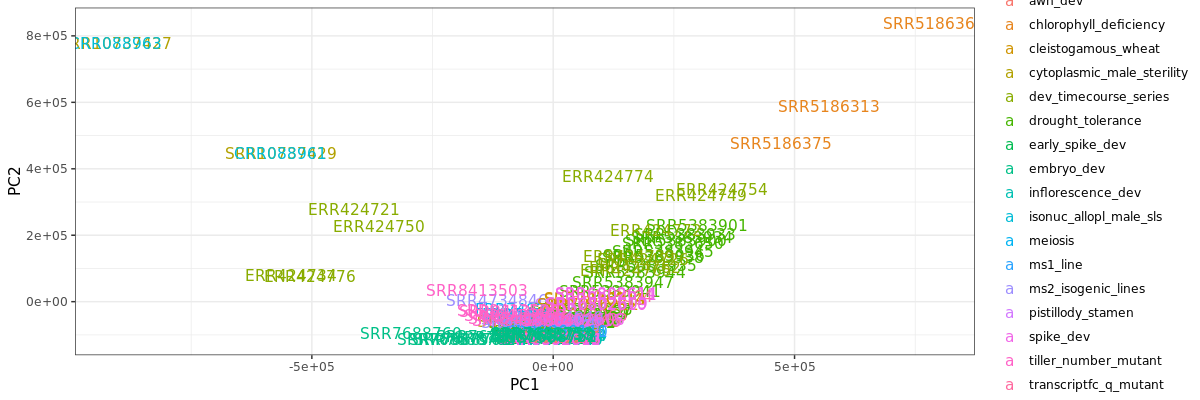

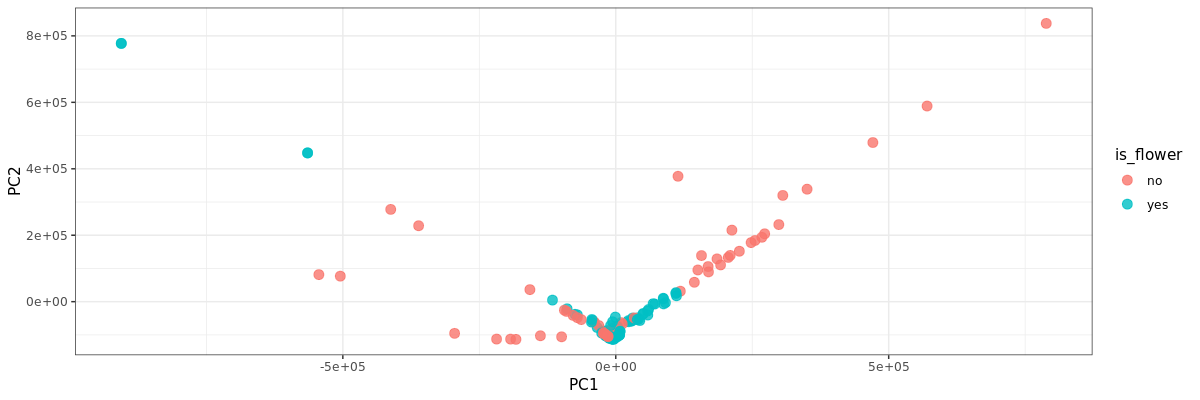

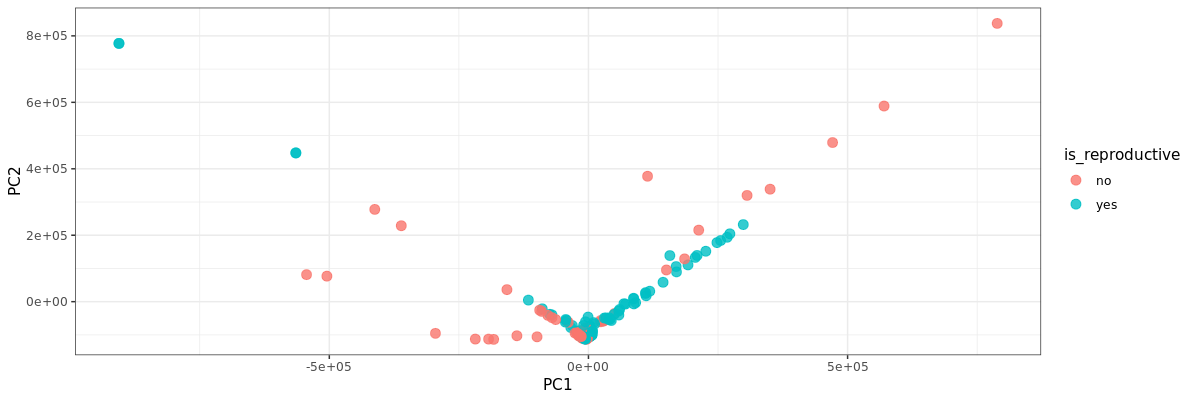

In [11]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_1, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_1, color_by = 'is_reproductive',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [12]:
# create models
so_1 <- sleuth_fit(so_1, ~dataset + is_flower + is_reproductive, 'full')
so_1 <- sleuth_fit(so_1, ~dataset + is_flower, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [13]:
# perform DGE tests
so_1 <- sleuth_lrt(so_1, 'reduced', 'full')
so_1 <- sleuth_wt(so_1, 'is_reproductiveyes', which_model = "full")

In [14]:
models(so_1)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	dataset

In [15]:
# exctract and inspect results of wald-test
so_wt <- sleuth_results(so_1,'is_reproductiveyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig <- filter(so_wt, qval < 0.05)
nrow(so_wt_sig)
table(so_wt_sig$b>0)

[1] 11544


FALSE  TRUE 
 4088  7456 

In [16]:
# extract and inspect results of lrt
so_lrt <- sleuth_results(so_1, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all <- na.omit(merge(so_lrt, so_wt, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,1.004391e-06,3.309334e-05,23.91969,74.98258,1,3.260173,9.451717,0.02939937,0.5610146,⋯,1.846916e-06,6.059137e-05,0.9262944,0.1942124,3.260173,9.451717,0.02939937,0.4746918,0.4539579,0.4746918
2,TraesCHI1A01G000300,4.441421e-11,1.166926e-08,43.40899,137.53588,1,1.522635,3.617255,0.07983076,1.0031290,⋯,3.046147e-11,8.143767e-09,1.6340636,0.2459338,1.522635,3.617255,0.07983076,0.7285048,0.6908053,0.7285048
3,TraesCHI1A01G000400,3.906660e-06,9.880932e-05,21.31011,136.23738,1,3.191348,2.800197,0.10173941,0.9709959,⋯,7.369073e-06,1.867700e-04,1.1841221,0.2641514,3.191348,2.800197,0.10173941,0.8307869,0.4724326,0.8307869


In [17]:
# inspect sig genes
table(so_all$qval.lrt<0.05)
table(so_all$qval.wt<0.05)
table(so_all$qval.lrt<0.05,so_all$qval.wt<0.05)


FALSE  TRUE 
45190 15765 


FALSE  TRUE 
49411 11544 

       
        FALSE  TRUE
  FALSE 45190     0
  TRUE   4221 11544

In [18]:
table1 <- select(so_all, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig1_1 <- filter(table1, qval.lrt <= 0.1)
glimpse(sig1_1)
sig1_05 <- filter(table1, qval.lrt <= 0.05)
glimpse(sig1_05)
sig1_01 <- filter(table1, qval.lrt <= 0.01)
glimpse(sig1_01)
# look at table and few of 0.05
head(sig1_05, 5)

Rows: 24,286
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 23.919691, 43.408994, 21.310108, 13.698400, 8.625827, 6.551…
$ b         <dbl> 0.926294392, 1.634063642, 1.184122124, -1.069419747, -0.248…
$ qval.lrt  <dbl> 3.309334e-05, 1.166926e-08, 9.880932e-05, 2.421920e-03, 1.9…
$ qval.wt   <dbl> 6.059137e-05, 8.143767e-09, 1.867700e-04, 4.363528e-03, 3.1…
Rows: 15,765
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 23.919691, 43.408994, 21.310108, 13.698400, 8.625827, 6.551…
$ b         <dbl> 0.9262944, 1.6340636, 1.1841221, -1.0694197, -0.2485914, 0.…
$ qval.lrt  <dbl> 3.309334e-05, 1.166926e-08, 9.880932e-05, 2.421920e-03, 1.9…
$ qval.wt   <dbl> 6.059137e-05, 8.143767e-09, 1.867700e-04, 4.363528e-03, 3.1…
Rows: 8,476
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 23.91969, 43.40899, 21.31011, 13.69840, 26

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,23.919691,0.9262944,3.309334e-05,6.059137e-05
2,TraesCHI1A01G000300,43.408994,1.6340636,1.166926e-08,8.143767e-09
3,TraesCHI1A01G000400,21.310108,1.1841221,9.880932e-05,1.867700e-04
4,TraesCHI1A01G001700,13.698400,-1.0694197,2.421920e-03,4.363528e-03
5,TraesCHI1A01G002200,8.625827,-0.2485914,1.908420e-02,3.124203e-02


In [19]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig1_1, file = "wdeg1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig1_05, file = "wdeg1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig1_01, file = "wdeg1_signif0_01.csv", sep = ",", col.names = TRUE)

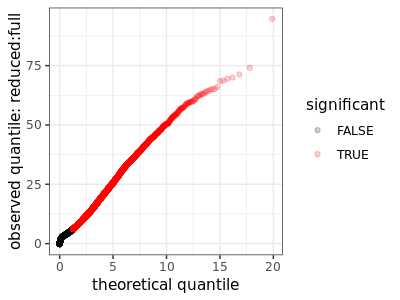

In [20]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

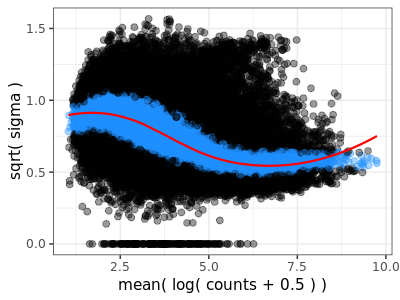

In [21]:
plot_mean_var(so_1,which_model="full")

# 2. contrast: **all vs flower** reverse of the 1. contrast!
* all vs flower targeting tissue difference: 0-30 & 70-99 of nonflower tissues vs 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_reproductive[yes-no]`
         - `full = dataset + is_reproductive[yes-no] + is_flower[yes-no]`
* use same sleuth object, only change designs!

In [22]:
# create models on the same object
so_2 <- sleuth_fit(so_1, ~dataset + is_reproductive + is_flower, 'full')
so_2 <- sleuth_fit(so_1, ~dataset + is_reproductive, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [23]:
# perform DGE tests
so_2 <- sleuth_lrt(so_2, 'reduced', 'full')
so_2 <- sleuth_wt(so_2, 'is_floweryes', which_model = "full")

In [24]:
models(so_2)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	d

In [25]:
# exctract and inspect results of wald-test
so_wt2 <- sleuth_results(so_2,'is_floweryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig2 <- filter(so_wt2, qval < 0.05)
nrow(so_wt_sig2)
table(so_wt_sig2$b>0)

[1] 13800


FALSE  TRUE 
 7619  6181 

In [26]:
# extract and inspect results of lrt
so_lrt2 <- sleuth_results(so_2, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all2 <- na.omit(merge(so_lrt2, so_wt, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all2, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.02189759,0.05602568,5.25390387,65.92556,1,3.260173,9.451717,0.02939937,0.4896995,⋯,1.846916e-06,6.059137e-05,0.9262944,0.1942124,3.260173,9.451717,0.02939937,0.4746918,0.4539579,0.4746918
2,TraesCHI1A01G000300,0.53974698,0.59908003,0.37600891,101.98243,1,1.522635,3.617255,0.07983076,0.7231805,⋯,3.046147e-11,8.143767e-09,1.6340636,0.2459338,1.522635,3.617255,0.07983076,0.7285048,0.6908053,0.7285048
3,TraesCHI1A01G000400,1.00000000,1.00000000,-0.07266781,117.55795,1,3.191348,2.800197,0.10173941,0.8239138,⋯,7.369073e-06,1.867700e-04,1.1841221,0.2641514,3.191348,2.800197,0.10173941,0.8307869,0.4724326,0.8307869


In [27]:
# inspect sig genes
table(so_all2$qval.lrt<0.05)
table(so_all2$qval.wt<0.05)
table(so_all2$qval.lrt<0.05,so_all2$qval.wt<0.05)


FALSE  TRUE 
39130 21825 


FALSE  TRUE 
49411 11544 

       
        FALSE  TRUE
  FALSE 31673  7457
  TRUE  17738  4087

In [28]:
table2 <- select(so_all2, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig2_1 <- filter(table2, qval.lrt <= 0.1)
glimpse(sig2_1)
sig2_05 <- filter(table2, qval.lrt <= 0.05)
glimpse(sig2_05)
sig2_01 <- filter(table2, qval.lrt <= 0.01)
glimpse(sig2_01)
# look at table and few of 0.05
head(sig2_05, 5)

Rows: 35,927
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G002100", "TraesCHI1A01…
$ test_stat <dbl> 5.253904, 20.163670, 8.853279, 4.273814, 4.473173, 5.695650…
$ b         <dbl> 0.926294392, 0.124701862, -0.248591351, 0.108533192, 0.3448…
$ qval.lrt  <dbl> 0.0560256808, 0.0001127293, 0.0143850694, 0.0767980744, 0.0…
$ qval.wt   <dbl> 6.059137e-05, 7.245066e-01, 3.124203e-02, 5.236059e-01, 5.1…
Rows: 21,825
Columns: 5
$ target_id <chr> "TraesCHI1A01G002100", "TraesCHI1A01G002200", "TraesCHI1A01…
$ test_stat <dbl> 20.163670, 8.853279, 5.695650, 6.831324, 10.026831, 6.53722…
$ b         <dbl> 0.124701862, -0.248591351, 0.194185941, -0.056988582, -0.07…
$ qval.lrt  <dbl> 1.127293e-04, 1.438507e-02, 4.848127e-02, 3.213037e-02, 8.8…
$ qval.wt   <dbl> 7.245066e-01, 3.124203e-02, 3.861847e-01, 7.327787e-01, 7.7…
Rows: 11,074
Columns: 5
$ target_id <chr> "TraesCHI1A01G002100", "TraesCHI1A01G009000", "TraesCHI1A01…
$ test_stat <dbl> 20.16367, 10.02683, 14.93397, 17.64231, 2

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G002100,20.163670,0.12470186,0.0001127293,0.72450663
2,TraesCHI1A01G002200,8.853279,-0.24859135,0.0143850694,0.03124203
3,TraesCHI1A01G002800,5.695650,0.19418594,0.0484812671,0.38618465
4,TraesCHI1A01G006900,6.831324,-0.05698858,0.0321303715,0.73277870
5,TraesCHI1A01G009000,10.026831,-0.07806121,0.0088241618,0.77314461


In [29]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig2_1, file = "wdeg2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig2_05, file = "wdeg2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig2_01, file = "wdeg2_signif0_01.csv", sep = ",", col.names = TRUE)

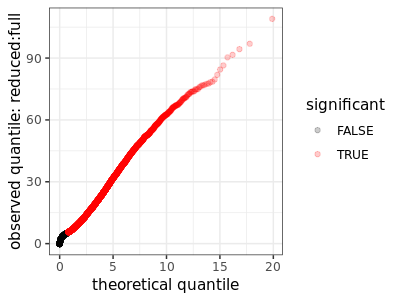

In [30]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

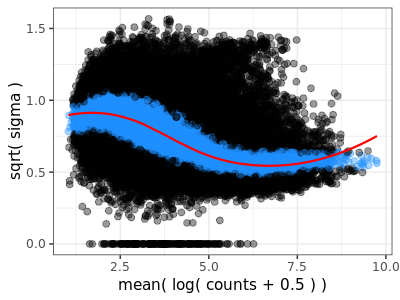

In [31]:
plot_mean_var(so_2, which_model="full")

# 3_0. Contrast: **non_primordium vs primordium** 
* using only meristem + flower tissues, 
* targeting time difference, 
* correcting with intermediate_tissue, 
* mutants excluded
* dataset caused singularity!
     - `null = dataset`
     - `full = dataset + is_primordium`
* Create contrast variables:
     - **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues

In [32]:
# here leave only wt samples and flower+meristem tissues in the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- b_meta %>% filter(gm == "wt") %>%
                                    filter(high_level_tissue == "inflorescence" | high_level_tissue == "meristem") %>% 
                                    select(ID, dataset, library, intermediate_tissue, zadok_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadok_scale <= 30 & zadok_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, library, intermediate_tissue, is_primordium, dataset)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadok_scale >= 31 & zadok_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, library, intermediate_tissue, is_primordium, dataset)
# here we join tables of primordium stage or not into one
b_30 <- bind_rows(is_primordium_yes, is_primordium_no)
b_30$ID <- as.factor(b_30$ID)
b_30$library <- as.factor(b_30$library)
b_30$dataset <- as.factor(b_30$dataset)
b_30$is_primordium <- as.factor(b_30$is_primordium)
# inspect ratios of groups
glimpse(is_primordium_tissue) # flower & meristem tissues
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
# inspect full dataset
glimpse(b_30)
tail(b_30, 3)

Rows: 93
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ zadok_scale         <int> 56, 56, 56, 56, 56, 56, 71, 71, 71, 71, 71, 71, 6…
Rows: 22
Columns: 5
$ ID                  <chr> "SRR3659902", "SRR3659901", "SRR3659900", "SRR365…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ is_primordium       <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
$ dataset             <chr> "early_spike_dev", "early_spike_dev", "early_spik…
Rows: 63
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ library             <chr> "paired", "paired", "paired", "paired", "pa

,ID,library,intermediate_tissue,is_primordium,dataset
,<fct>,<fct>,<chr>,<fct>,<fct>
83,SRR6802613,paired,ovary,no,spike_dev
84,SRR6802614,paired,spike,no,spike_dev
85,SRR6802615,paired,rachis,no,spike_dev


In [33]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_30$ID, "abundance.h5")
names(files) <- paste0(b_30$ID)
head(files)
all(file.exists(files))

SRR3659902 
"../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5" 
                                                 SRR3659901 
"../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5" 
                                                 SRR3659900 
"../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5" 
                                                 SRR3659899 
"../04_Kallisto_allreads_symlinked/SRR3659899/abundance.h5" 
                                                 SRR3659898 
"../04_Kallisto_allreads_symlinked/SRR3659898/abundance.h5" 
                                                 SRR3659897 
"../04_Kallisto_allreads_symlinked/SRR3659897/abundance.h5"

[1] TRUE

In [34]:
s2c_30 <- mutate(b_30, path = files, sample = ID)
head(s2c_30, 3)

,ID,library,intermediate_tissue,is_primordium,dataset,path,sample
,<fct>,<fct>,<chr>,<fct>,<fct>,<chr>,<fct>
1,SRR3659902,paired,spike,yes,early_spike_dev,../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5,SRR3659902
2,SRR3659901,paired,spike,yes,early_spike_dev,../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5,SRR3659901
3,SRR3659900,paired,spike,yes,early_spike_dev,../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5,SRR3659900


In [35]:
# construct the sleuth-object
so_30 <- sleuth_prep(sample_to_covariates = s2c_30, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.....................................................................................
normalizing est_counts
60522 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60522 genes passed the filter
summarizing bootstraps
.................................................
....................................


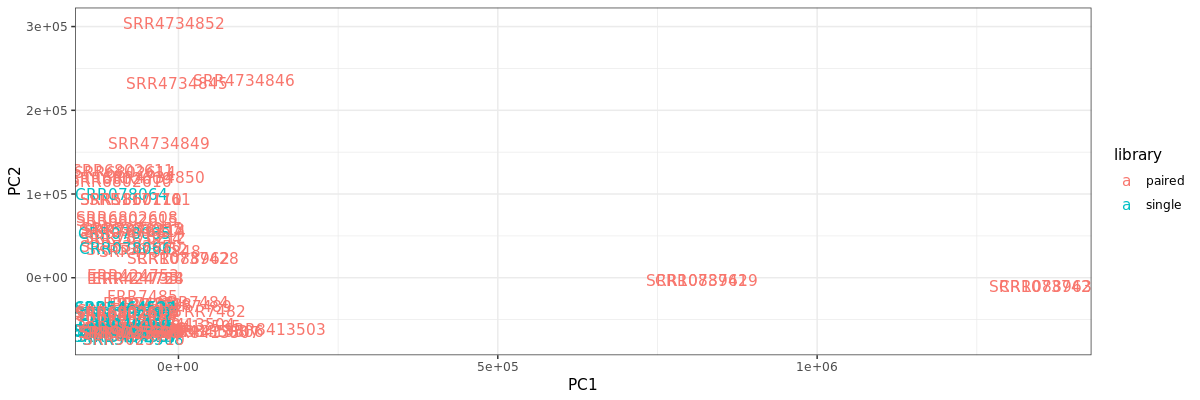

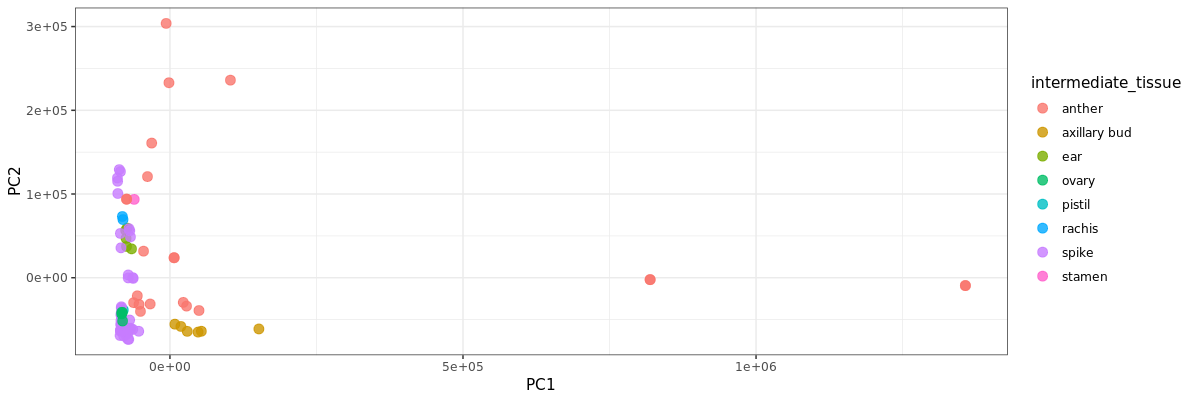

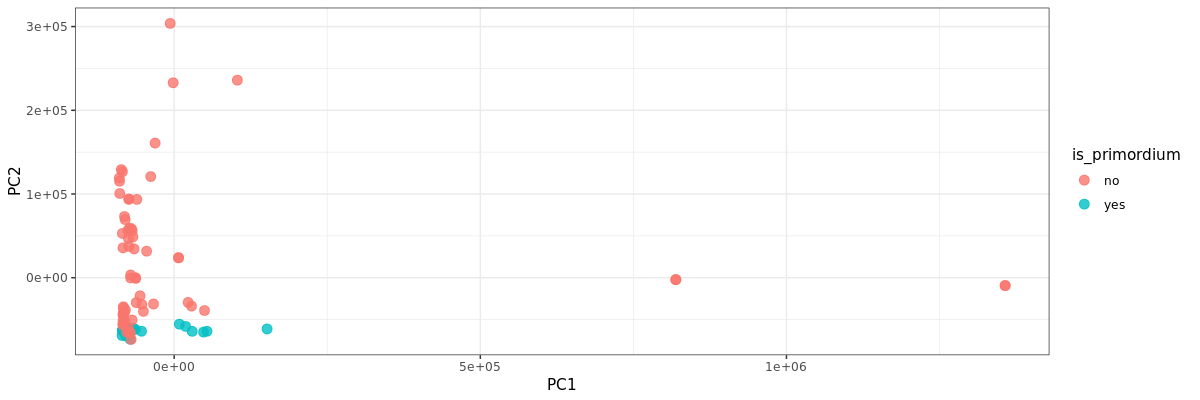

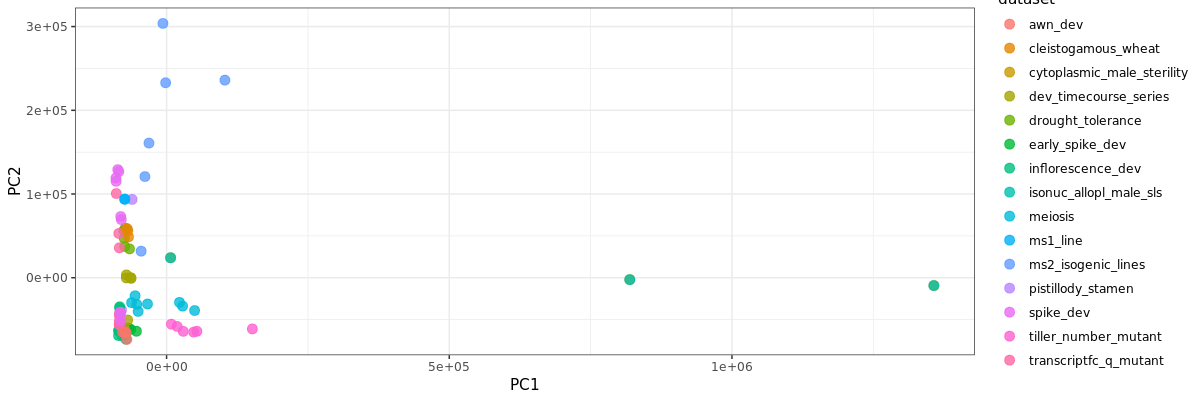

In [36]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_30, color_by = 'library',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'dataset',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [37]:
# create models
so_30 <- sleuth_fit(so_30, ~dataset + is_primordium, 'full')
so_30 <- sleuth_fit(so_30, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [38]:
# perform DGE tests
so_30 <- sleuth_lrt(so_30, 'reduced', 'full')
so_30 <- sleuth_wt(so_30, 'is_primordiumyes', which_model = "full")

In [39]:
models(so_30)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettiller_number_mutant
 	datasettranscri

In [40]:
# exctract and inspect results of wald-test
so_wt30 <- sleuth_results(so_30,'is_primordiumyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig30 <- filter(so_wt30, qval < 0.05)
nrow(so_wt_sig30)
table(so_wt_sig30$b>0)

[1] 9200


FALSE  TRUE 
 6368  2832 

In [41]:
# extract and inspect results of lrt
so_lrt30 <- sleuth_results(so_30, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all30 <- na.omit(merge(so_lrt30, so_wt30, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all30, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,1.000000000,1.00000000,-0.1911049,28.80210,1,3.118585,10.763836,0.04860363,0.3628549,⋯,0.87206936,0.9513454,0.08493144,0.5274245,3.118585,10.763836,0.04860363,0.36866127,0.2775811,0.3686613
2,TraesCHI1A01G000300,0.005299538,0.03201041,7.7742785,23.84580,1,1.471535,3.342037,0.08652157,0.2541327,⋯,0.04441908,0.1761454,-1.20965450,0.6017839,1.471535,3.342037,0.08652157,0.22725963,0.4566942,0.4566942
3,TraesCHI1A01G000400,0.023089767,0.08876573,5.1617390,12.34941,1,3.523622,2.240998,0.07318843,0.1032317,⋯,0.05439798,0.2015473,0.83580505,0.4344883,3.523622,2.240998,0.07318843,0.09060225,0.2099817,0.2099817


In [42]:
# inspect sig genes
table(so_all30$qval.lrt<0.05)
table(so_all30$qval.wt<0.05)
table(so_all30$qval.lrt<0.05,so_all30$qval.wt<0.05)


FALSE  TRUE 
48634 11888 


FALSE  TRUE 
51322  9200 

       
        FALSE  TRUE
  FALSE 48634     0
  TRUE   2688  9200

In [43]:
table30 <- select(so_all30, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig30_1 <- filter(table30, qval.lrt <= 0.1)
glimpse(sig30_1)
sig30_05 <- filter(table30, qval.lrt <= 0.05)
glimpse(sig30_05)
sig30_01 <- filter(table30, qval.lrt <= 0.01)
glimpse(sig30_01)
# look at table and few of 0.05
head(sig30_05, 5)

Rows: 16,842
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 7.774279, 5.161739, 20.854276, 6.053457, 31.381533, 7.77424…
$ b         <dbl> -1.2096545, 0.8358051, 3.8814212, 0.4720492, -4.1543294, 1.…
$ qval.lrt  <dbl> 3.201041e-02, 8.876573e-02, 1.307963e-04, 6.354900e-02, 1.6…
$ qval.wt   <dbl> 1.761454e-01, 2.015473e-01, 2.746508e-04, 1.067820e-01, 1.9…
Rows: 11,888
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G001700", "TraesCHI1A01…
$ test_stat <dbl> 7.774279, 20.854276, 31.381533, 7.774246, 11.233581, 13.747…
$ b         <dbl> -1.2096545, 3.8814212, -4.1543294, 1.6551018, 0.6293473, -3…
$ qval.lrt  <dbl> 3.201041e-02, 1.307963e-04, 1.621987e-06, 3.201041e-02, 7.7…
$ qval.wt   <dbl> 1.761454e-01, 2.746508e-04, 1.918328e-06, 6.335113e-02, 2.3…
Rows: 6,853
Columns: 5
$ target_id <chr> "TraesCHI1A01G001700", "TraesCHI1A01G004700", "TraesCHI1A01…
$ test_stat <dbl> 20.85428, 31.38153, 11.23358, 13.74782, 57

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000300,7.774279,-1.2096545,3.201041e-02,1.761454e-01
2,TraesCHI1A01G001700,20.854276,3.8814212,1.307963e-04,2.746508e-04
3,TraesCHI1A01G004700,31.381533,-4.1543294,1.621987e-06,1.918328e-06
4,TraesCHI1A01G006000,7.774246,1.6551018,3.201041e-02,6.335113e-02
5,TraesCHI1A01G006900,11.233581,0.6293473,7.731812e-03,2.300071e-02


In [44]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig30_1, file = "wdeg30_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig30_05, file = "wdeg30_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig30_01, file = "wdeg30_signif0_01.csv", sep = ",", col.names = TRUE)

# 3. Contrast: **non_primordium vs primordium** 
* using only meristem + flower tissues, 
* targeting time difference, 
* correcting with intermediate_tissue, 
* mutants excluded
* dataset caused singularity!
     - `null = intermediate_tissue`
     - `full = intermediate_tissue + is_primordium`
* Create contrast variables:
     - **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues

In [45]:
# here leave only wt samples and flower+meristem tissues in the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- b_meta %>% filter(gm == "wt") %>%
                                    filter(high_level_tissue == "inflorescence" |
                                            high_level_tissue == "meristem") %>% select(ID, library, intermediate_tissue, zadok_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadok_scale <= 30 & zadok_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, library, intermediate_tissue, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadok_scale >= 31 & zadok_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, library, intermediate_tissue, is_primordium)
# here we join tables of primordium stage or not into one
b_3 <- bind_rows(is_primordium_yes, is_primordium_no)
b_3$ID <- as.factor(b_3$ID)
b_3$library <- as.factor(b_3$library)
b_3$is_primordium <- as.factor(b_3$is_primordium)
# inspect ratios of groups
glimpse(is_primordium_tissue) # flower & meristem tissues
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
# inspect full dataset
glimpse(b_3)
tail(b_3, 3)

Rows: 93
Columns: 4
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ zadok_scale         <int> 56, 56, 56, 56, 56, 56, 71, 71, 71, 71, 71, 71, 6…
Rows: 22
Columns: 4
$ ID                  <chr> "SRR3659902", "SRR3659901", "SRR3659900", "SRR365…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ is_primordium       <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 63
Columns: 4
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ is_primordium       <chr> "no", "no", "no", "no", "no", "no", "no", "

,ID,library,intermediate_tissue,is_primordium
,<fct>,<fct>,<chr>,<fct>
83,SRR6802613,paired,ovary,no
84,SRR6802614,paired,spike,no
85,SRR6802615,paired,rachis,no


In [46]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_3$ID, "abundance.h5")
names(files) <- paste0(b_3$ID)
head(files)
all(file.exists(files))

SRR3659902 
"../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5" 
                                                 SRR3659901 
"../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5" 
                                                 SRR3659900 
"../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5" 
                                                 SRR3659899 
"../04_Kallisto_allreads_symlinked/SRR3659899/abundance.h5" 
                                                 SRR3659898 
"../04_Kallisto_allreads_symlinked/SRR3659898/abundance.h5" 
                                                 SRR3659897 
"../04_Kallisto_allreads_symlinked/SRR3659897/abundance.h5"

[1] TRUE

In [47]:
s2c_3 <- mutate(b_3, path = files, sample = ID)
head(s2c_3, 3)

,ID,library,intermediate_tissue,is_primordium,path,sample
,<fct>,<fct>,<chr>,<fct>,<chr>,<fct>
1,SRR3659902,paired,spike,yes,../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5,SRR3659902
2,SRR3659901,paired,spike,yes,../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5,SRR3659901
3,SRR3659900,paired,spike,yes,../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5,SRR3659900


In [48]:
# construct the sleuth-object
so_3 <- sleuth_prep(sample_to_covariates = s2c_3, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.....................................................................................
normalizing est_counts
60522 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60522 genes passed the filter
summarizing bootstraps
.................................................
....................................


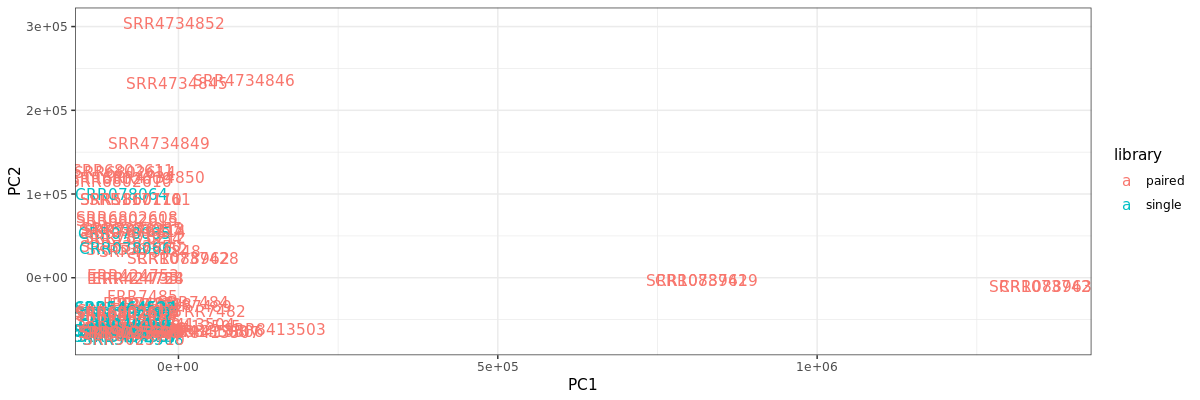

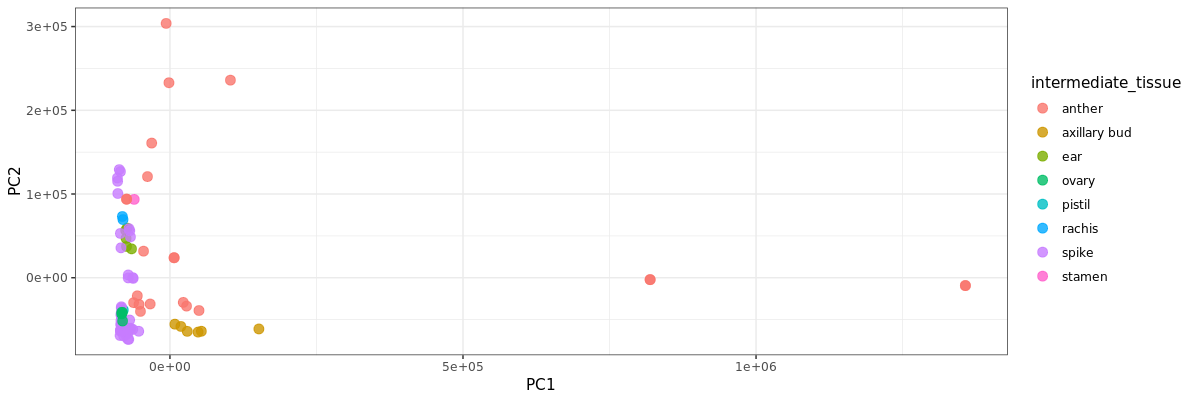

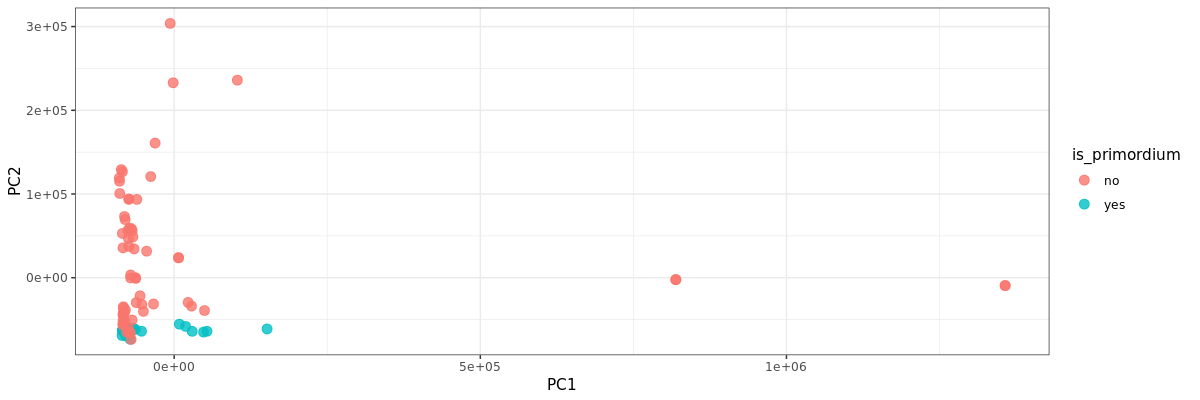

In [49]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_3, color_by = 'library',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_3, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_3, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [50]:
# create models
so_3 <- sleuth_fit(so_3, ~intermediate_tissue + is_primordium, 'full')
so_3 <- sleuth_fit(so_3, ~intermediate_tissue, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [51]:
# perform DGE tests
so_3 <- sleuth_lrt(so_3, 'reduced', 'full')
so_3 <- sleuth_wt(so_3, 'is_primordiumyes', which_model = "full")

In [52]:
models(so_3)

[  full  ]
formula:  ~intermediate_tissue + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueaxillary bud
 	intermediate_tissueear
 	intermediate_tissueovary
 	intermediate_tissuepistil
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen
 	is_primordiumyes
[  reduced  ]
formula:  ~intermediate_tissue 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueaxillary bud
 	intermediate_tissueear
 	intermediate_tissueovary
 	intermediate_tissuepistil
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen


In [53]:
# exctract and inspect results of wald-test
so_wt3 <- sleuth_results(so_3,'is_primordiumyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig3 <- filter(so_wt3, qval < 0.05)
nrow(so_wt_sig3)
table(so_wt_sig3$b>0)

[1] 32063


FALSE  TRUE 
19979 12084 

In [54]:
# extract and inspect results of lrt
so_lrt3 <- sleuth_results(so_3, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all3 <- na.omit(merge(so_lrt3, so_wt3, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all3, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.36561674,0.39339111,0.818508,704.2018,1,3.118585,10.763836,0.04860363,9.096875,⋯,0.36061079,0.45423090,-0.8673538,0.9487553,3.118585,10.763836,0.04860363,9.116423,0.7325683,9.116423
2,TraesCHI1A01G000300,0.02469042,0.03101903,5.045469,205.8076,1,1.471535,3.342037,0.08652157,2.586305,⋯,0.02924168,0.05447442,-1.0907790,0.5003085,1.471535,3.342037,0.08652157,2.462075,1.1024179,2.462075
3,TraesCHI1A01G000400,0.01345837,0.01770519,6.107838,123.2898,1,3.523622,2.240998,0.07318843,1.527978,⋯,0.01631174,0.03273707,0.9242836,0.3848192,3.523622,2.240998,0.07318843,1.434594,0.5633033,1.434594


In [55]:
# inspect sig genes
table(so_all3$qval.lrt<0.05)
table(so_all3$qval.wt<0.05)
table(so_all3$qval.lrt<0.05,so_all3$qval.wt<0.05)


FALSE  TRUE 
10627 49895 


FALSE  TRUE 
28459 32063 

       
        FALSE  TRUE
  FALSE 10627     0
  TRUE  17832 32063

In [56]:
table3 <- select(so_all3, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig3_1 <- filter(table3, qval.lrt <= 0.1)
glimpse(sig3_1)
sig3_05 <- filter(table3, qval.lrt <= 0.05)
glimpse(sig3_05)
sig3_01 <- filter(table3, qval.lrt <= 0.01)
glimpse(sig3_01)
# look at table and few of 0.05
head(sig3_05, 5)

Rows: 52,114
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 5.045469, 6.107838, 60.284761, 43.994968, 10.143211, 10.766…
$ b         <dbl> -1.0907790, 0.9242836, -1.6270396, -1.4996694, -0.2191859, …
$ qval.lrt  <dbl> 3.101903e-02, 1.770519e-02, 2.433940e-13, 4.591041e-10, 2.4…
$ qval.wt   <dbl> 5.447442e-02, 3.273707e-02, 2.350556e-17, 9.591186e-12, 1.7…
Rows: 49,895
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 5.045469, 6.107838, 60.284761, 43.994968, 10.143211, 10.766…
$ b         <dbl> -1.0907790, 0.9242836, -1.6270396, -1.4996694, -0.2191859, …
$ qval.lrt  <dbl> 3.101903e-02, 1.770519e-02, 2.433940e-13, 4.591041e-10, 2.4…
$ qval.wt   <dbl> 5.447442e-02, 3.273707e-02, 2.350556e-17, 9.591186e-12, 1.7…
Rows: 43,468
Columns: 5
$ target_id <chr> "TraesCHI1A01G002100", "TraesCHI1A01G002200", "TraesCHI1A01…
$ test_stat <dbl> 60.284761, 43.994968, 10.143211, 10.76641

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000300,5.045469,-1.0907790,3.101903e-02,5.447442e-02
2,TraesCHI1A01G000400,6.107838,0.9242836,1.770519e-02,3.273707e-02
3,TraesCHI1A01G002100,60.284761,-1.6270396,2.433940e-13,2.350556e-17
4,TraesCHI1A01G002200,43.994968,-1.4996694,4.591041e-10,9.591186e-12
5,TraesCHI1A01G002300,10.143211,-0.2191859,2.471696e-03,1.740483e-01


In [57]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig3_1, file = "wdeg3_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig3_05, file = "wdeg3_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig3_01, file = "wdeg3_signif0_01.csv", sep = ",", col.names = TRUE)

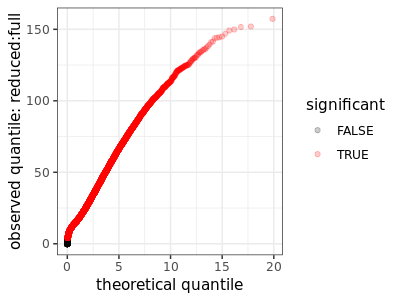

In [58]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_3, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

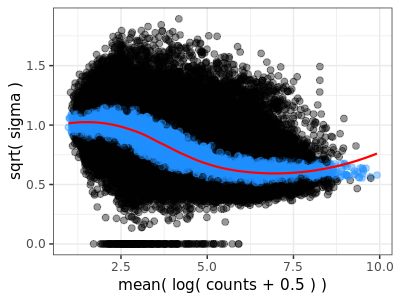

In [59]:
plot_mean_var(so_3, which_model="full")

# 4. Contrast: **non_primordium vs primordium** - reverse of the 3. contrast!
* using only meristem + flower tissues, 
* targeting tissue difference, 
* correcting with time, 
* mutants excluded
     - `null = dataset + is_primordium + intermediate_tissue`
     - `full = dataset + is_primordium`

In [60]:
# create models
so_4 <- sleuth_fit(so_3, ~is_primordium + intermediate_tissue, 'full')
so_4 <- sleuth_fit(so_3, ~is_primordium, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [64]:
# perform DGE tests
so_4 <- sleuth_lrt(so_4, 'reduced', 'full')
so_4 <- sleuth_wt(so_4, 'is_primordiumyes', which_model = "full")

In [65]:
models(so_4)

[  full  ]
formula:  ~intermediate_tissue + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueaxillary bud
 	intermediate_tissueear
 	intermediate_tissueovary
 	intermediate_tissuepistil
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen
 	is_primordiumyes
[  reduced  ]
formula:  ~is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	is_primordiumyes


In [68]:
# exctract and inspect results of wald-test
so_wt4 <- sleuth_results(so_4,'is_primordiumyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig4 <- filter(so_wt4, qval < 0.05)
nrow(so_wt_sig4)
table(so_wt_sig4$b>0)

[1] 32063


FALSE  TRUE 
19979 12084 

In [69]:
# extract and inspect results of lrt
so_lrt4 <- sleuth_results(so_4, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all4 <- na.omit(merge(so_lrt4, so_wt4, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all4, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,5.646533e-02,5.903561e-02,13.71621,823.2415,7,3.118585,10.763836,0.04860363,9.869969,⋯,0.36061079,0.45423090,-0.8673538,0.9487553,3.118585,10.763836,0.04860363,9.116423,0.7325683,9.116423
2,TraesCHI1A01G000300,3.031502e-04,4.204518e-04,27.22846,268.3696,7,1.471535,3.342037,0.08652157,3.146848,⋯,0.02924168,0.05447442,-1.0907790,0.5003085,1.471535,3.342037,0.08652157,2.462075,1.1024179,2.462075
3,TraesCHI1A01G000400,2.387241e-05,4.533721e-05,33.24124,170.4090,7,3.523622,2.240998,0.07318843,1.979932,⋯,0.01631174,0.03273707,0.9242836,0.3848192,3.523622,2.240998,0.07318843,1.434594,0.5633033,1.434594


In [70]:
# inspect sig genes
table(so_all4$qval.lrt<0.05)
table(so_all4$qval.wt<0.05)
table(so_all4$qval.lrt<0.05,so_all4$qval.wt<0.05)


FALSE  TRUE 
 2866 57656 


FALSE  TRUE 
28459 32063 

       
        FALSE  TRUE
  FALSE  1500  1366
  TRUE  26959 30697

In [71]:
table4 <- select(so_all4, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig4_1 <- filter(table4, qval.lrt <= 0.1)
glimpse(sig4_1)
sig4_05 <- filter(table4, qval.lrt <= 0.05)
glimpse(sig4_05)
sig4_01 <- filter(table4, qval.lrt <= 0.01)
glimpse(sig4_01)
# look at table and few of 0.05
head(sig4_05, 5)

Rows: 58,586
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 13.71621, 27.22846, 33.24124, 33.74034, 53.10064, 36.17630,…
$ b         <dbl> -0.86735383, -1.09077902, 0.92428359, 0.68015733, 0.6293533…
$ qval.lrt  <dbl> 5.903561e-02, 4.204518e-04, 4.533721e-05, 3.772468e-05, 2.3…
$ qval.wt   <dbl> 4.542309e-01, 5.447442e-02, 3.273707e-02, 4.936047e-01, 2.4…
Rows: 57,656
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 27.22846, 33.24124, 33.74034, 53.10064, 36.17630, 36.02451,…
$ b         <dbl> -1.09077902, 0.92428359, 0.68015733, 0.62935330, -1.6270396…
$ qval.lrt  <dbl> 4.204518e-04, 4.533721e-05, 3.772468e-05, 2.385289e-08, 1.5…
$ qval.wt   <dbl> 5.447442e-02, 3.273707e-02, 4.936047e-01, 2.471672e-01, 2.3…
Rows: 54,542
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 27.22846, 33.24124, 33.74034, 53.10064, 3

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000300,27.22846,-1.0907790,4.204518e-04,5.447442e-02
2,TraesCHI1A01G000400,33.24124,0.9242836,4.533721e-05,3.273707e-02
3,TraesCHI1A01G000900,33.74034,0.6801573,3.772468e-05,4.936047e-01
4,TraesCHI1A01G001700,53.10064,0.6293533,2.385289e-08,2.471672e-01
5,TraesCHI1A01G002100,36.17630,-1.6270396,1.544165e-05,2.350556e-17


In [72]:
# save 3 sets of DEGs in .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig4_1, file = "wdeg4_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig4_05, file = "wdeg4_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig4_01, file = "wdeg4_signif0_01.csv", sep = ",", col.names = TRUE)

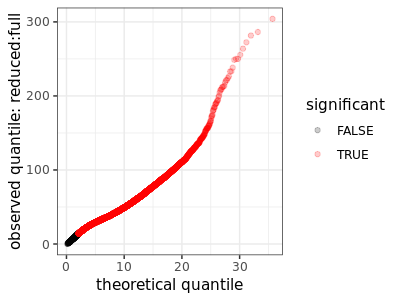

In [73]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_4, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

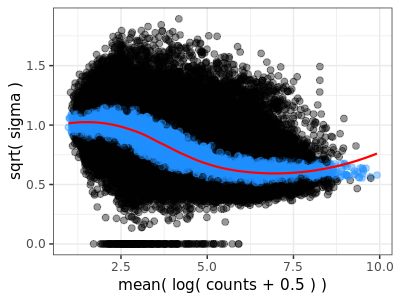

In [74]:
plot_mean_var(so_4, which_model="full")

# 5. **floret_dev vs heading/anthesis stage** 
* targeting time difference (is_heading), 
* correcting with tissues using intermediate_tissue, 
* only reproductive, mutants excluded:
     **barley**: using only flower tissues
     - `null = instrument + intermediate_tissue`
     - `full = instrument + intermediate_tissue + is_anthesis`
     **wheat**: using only anther+flower
     - `null = dataset`
     - `full = dataset + is_heading`
## Create contrast variables
* **is_anthesis**: yes = Anthesis high_level_age, no = Floret_development, high_level_age
* **is_heading**: yes = Heading high_level_age, no = Floret_development high_level_age

In [155]:
# here filter to flower tissues only
# dont use library in barley as only paired reads are selected!
# also, intermed_tissue singular with is_anthesis...
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_age == "Reproductive") %>%
                        filter(high_level_tissue == "inflorescence") %>% 
                        select(ID, instrument, dataset, intermediate_tissue, intermediate_age) 
# here we select samples that are anther/stamen tissue
is_anthesis_yes <- is_flower %>% filter(intermediate_age == "Heading") %>% 
                                add_column(is_anthesis = "yes") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we select samples that are not anther/stamen, but are flower
is_anthesis_no <- is_flower %>% filter(intermediate_age == "Floret_development") %>% 
                                add_column(is_anthesis = "no") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we join tables of anther or not into one table
b_5 <- bind_rows(is_anthesis_yes, is_anthesis_no)
#glimpse(b_5)
# create variable is_anther
#is_anther_yes <- b_5 %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "meiocyte") %>%
#                        add_column(is_anther = "yes") %>% 
#                        select(ID, instrument, dataset, is_anthesis, is_anther)
#is_anther_no <- b_5 %>% filter(intermediate_tissue != "anther" | intermediate_tissue != "meiocyte") %>%
#                        add_column(is_anther = "no") %>% 
#                        select(ID, instrument, dataset,is_anthesis, is_anther)
# here we join tables of anther or not into one table
#b_5 <- bind_rows(is_anther_yes, is_anther_no)
b_5$ID <- as.factor(b_5$ID)
b_5$instrument <- as.factor(b_5$instrument)
b_5$is_anthesis <- as.factor(b_5$is_anthesis)
#b_5$is_anther <- as.factor(b_5$is_anther)
b_5$intermediate_tissue <- as.factor(b_5$intermediate_tissue)
b_5$dataset <- as.factor(b_5$dataset)
# inspect ratios
glimpse(is_flower)
glimpse(is_anthesis_yes)
glimpse(is_anthesis_no)
#glimpse(is_anther_yes)
#glimpse(is_anther_no)
# inspect full dataset
glimpse(b_5)
tail(b_5, 3)

Rows: 63
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
Rows: 8
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ is_anthesis         <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 36
Columns: 5
$ ID                  <chr> "SRR1177761", "SRR1175868", "FRR7482", "FRR7483",…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000"

,ID,instrument,dataset,intermediate_tissue,is_anthesis
,<fct>,<fct>,<fct>,<fct>,<fct>
42,SRR6802613,Illumina HiSeq 2000,spike_dev,ovary,no
43,SRR6802614,Illumina HiSeq 2000,spike_dev,spike,no
44,SRR6802615,Illumina HiSeq 2000,spike_dev,rachis,no


In [156]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_5$ID, "abundance.h5")
names(files) <- paste0(b_5$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [157]:
s2c_5 <- mutate(b_5, path = files, sample = ID)
head(s2c_5, 3)

,ID,instrument,dataset,intermediate_tissue,is_anthesis,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [158]:
# construct the sleuth-object
so_5 <- sleuth_prep(sample_to_covariates = s2c_5, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                  aggregation_column="gene",
                  gene_mode = TRUE,
                  num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
............................................
normalizing est_counts
60831 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60831 genes passed the filter
summarizing bootstraps
............................................


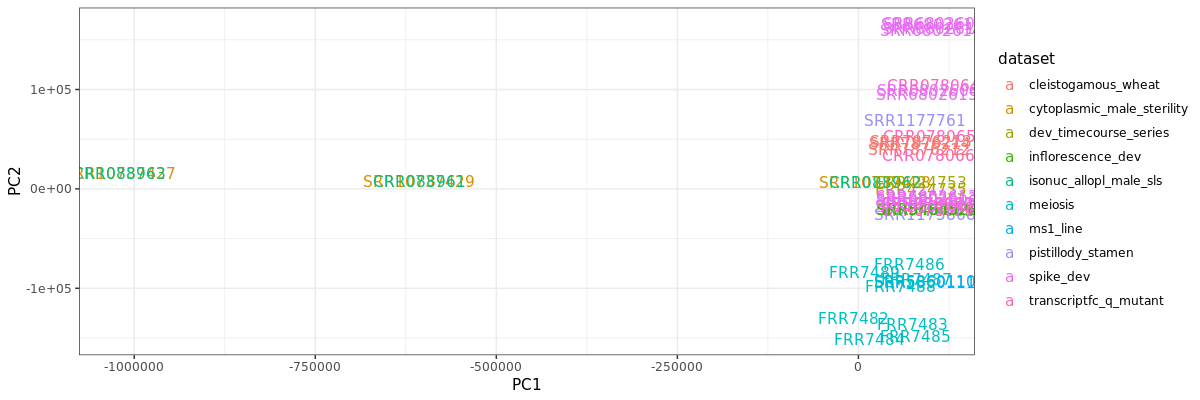

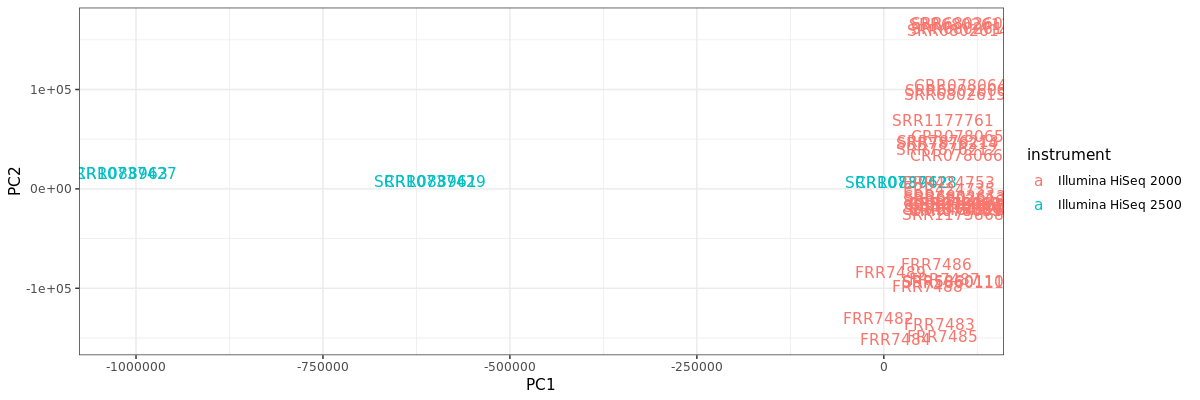

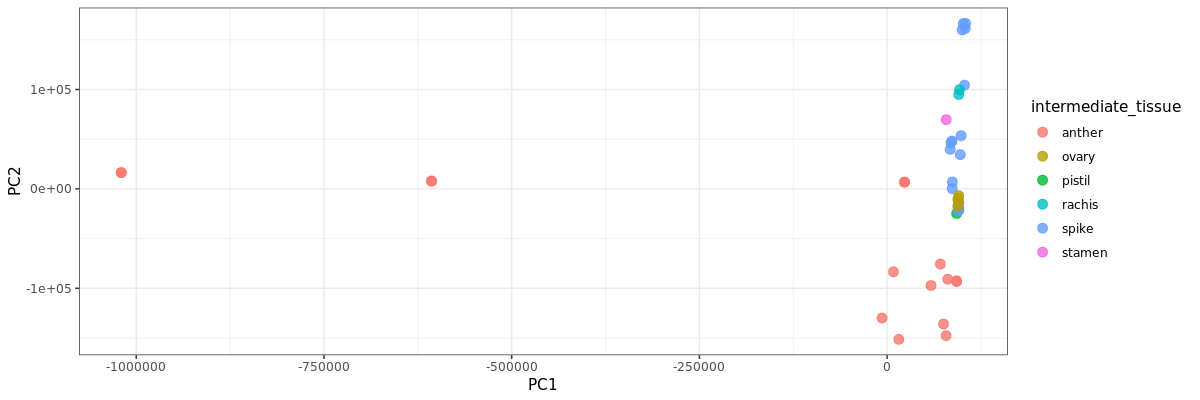

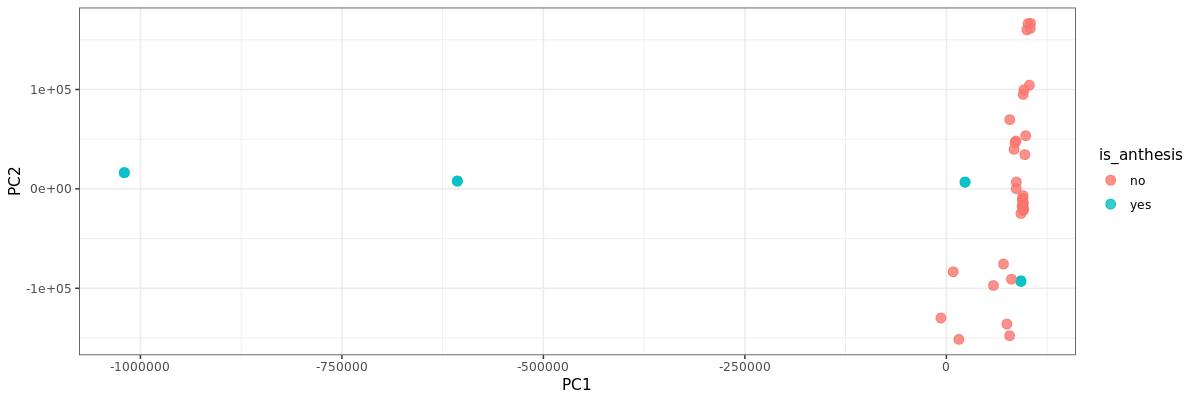

In [159]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_5, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'is_anthesis',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [160]:
# create models
so_5 <- sleuth_fit(so_5, ~instrument + is_anthesis, 'full')
so_5 <- sleuth_fit(so_5, ~instrument, 'reduced')

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1A01G385200, TraesCHI1D01G394300
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1A01G385200, TraesCHI1D01G394300
computing variance of betas


In [161]:
# perform DGE tests
so_5 <- sleuth_lrt(so_5, 'reduced', 'full')
so_5 <- sleuth_wt(so_5, 'is_anthesisyes', which_model = "full")

In [162]:
models(so_5)

[  full  ]
formula:  ~instrument + is_anthesis 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	is_anthesisyes
[  reduced  ]
formula:  ~instrument 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500


In [163]:
# exctract and inspect results of wald-test
so_wt5 <- sleuth_results(so_5,'is_anthesisyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig5 <- filter(so_wt5, qval < 0.05)
nrow(so_wt_sig5)
table(so_wt_sig5$b>0)

[1] 1368


FALSE  TRUE 
  786   582 

In [164]:
# extract and inspect results of lrt
so_lrt5 <- sleuth_results(so_5, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all5 <- na.omit(merge(so_lrt5, so_wt5, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all5, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.4331951,0.6562331,0.614242,302.72443,1,3.363330,9.698684,0.06659911,7.1411255,⋯,0.4261160,0.9488478,1.5590593,1.9589729,3.363330,9.698684,0.06659911,7.2045951,0.6806252,7.2045951
2,TraesCHI1A01G000300,0.2747533,0.6509933,1.192861,127.08269,1,1.539903,3.761066,0.06137864,2.9643998,⋯,0.2764421,0.8658360,-1.3723332,1.2609339,1.539903,3.761066,0.06137864,2.9511662,1.2363288,2.9511662
3,TraesCHI1A01G000400,0.2221694,0.6509933,1.490304,29.05718,1,2.938658,2.806815,0.08778539,0.6040522,⋯,0.2956374,0.8811152,0.7475389,0.7147773,2.938658,2.806815,0.08778539,0.5951018,0.8802482,0.8802482


In [165]:
# inspect sig genes
table(so_all5$qval.lrt<0.05)
table(so_all5$qval.wt<0.05)
table(so_all5$qval.lrt<0.05,so_all5$qval.wt<0.05)


FALSE  TRUE 
59570  1261 


FALSE  TRUE 
59463  1368 

       
        FALSE  TRUE
  FALSE 59456   114
  TRUE      7  1254

In [166]:
table5 <- select(so_all5, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig5_1 <- filter(table5, qval.lrt <= 0.1)
glimpse(sig5_1)
sig5_05 <- filter(table5, qval.lrt <= 0.05)
glimpse(sig5_05)
sig5_01 <- filter(table5, qval.lrt <= 0.01)
glimpse(sig5_01)
# look at table and few of 0.05
head(sig5_05, 5)

Rows: 1,841
Columns: 5
$ target_id <chr> "TraesCHI1A01G005000", "TraesCHI1A01G007100", "TraesCHI1A01…
$ test_stat <dbl> 18.277933, 29.990823, 19.048716, 39.214872, 39.214872, 39.2…
$ b         <dbl> -1.796853, 1.626902, -4.931355, -2.905856, -2.905856, -2.90…
$ qval.lrt  <dbl> 2.964606e-03, 1.941654e-05, 2.164526e-03, 2.537772e-07, 2.5…
$ qval.wt   <dbl> 7.601964e-04, 1.110162e-05, 4.491910e-04, 9.740766e-08, 9.7…
Rows: 1,261
Columns: 5
$ target_id <chr> "TraesCHI1A01G005000", "TraesCHI1A01G007100", "TraesCHI1A01…
$ test_stat <dbl> 18.27793, 29.99082, 19.04872, 39.21487, 39.21487, 39.21487,…
$ b         <dbl> -1.796853, 1.626902, -4.931355, -2.905856, -2.905856, -2.90…
$ qval.lrt  <dbl> 2.964606e-03, 1.941654e-05, 2.164526e-03, 2.537772e-07, 2.5…
$ qval.wt   <dbl> 7.601964e-04, 1.110162e-05, 4.491910e-04, 9.740766e-08, 9.7…
Rows: 599
Columns: 5
$ target_id <chr> "TraesCHI1A01G005000", "TraesCHI1A01G007100", "TraesCHI1A01…
$ test_stat <dbl> 18.27793, 29.99082, 19.04872, 39.21487, 39.214

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G005000,18.27793,-1.796853,2.964606e-03,7.601964e-04
2,TraesCHI1A01G007100,29.99082,1.626902,1.941654e-05,1.110162e-05
3,TraesCHI1A01G009400,19.04872,-4.931355,2.164526e-03,4.491910e-04
4,TraesCHI1A01G009900,39.21487,-2.905856,2.537772e-07,9.740766e-08
5,TraesCHI1A01G011700,39.21487,-2.905856,2.537772e-07,9.740766e-08


In [167]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig5_1, file = "wdeg5_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig5_05, file = "wdeg5_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig5_01, file = "wdeg5_signif0_01.csv", sep = ",", col.names = TRUE)

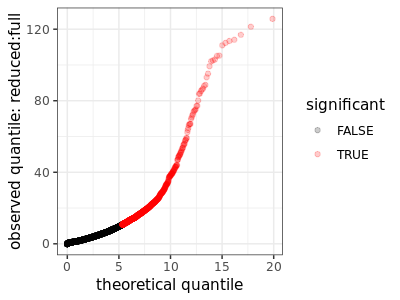

In [168]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_5, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

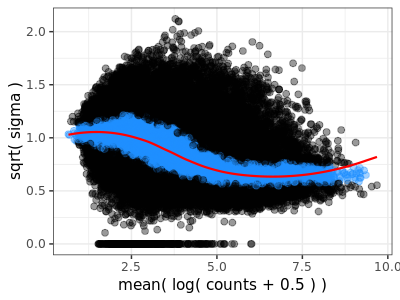

In [169]:
plot_mean_var(so_5, which_model="full")

# 6. **floret_dev vs heading stage** 
* targeting time difference (is_heading), 
* correcting with tissues using intermediate_tissue, 
* only reproductive, mutants excluded:
     **barley**: using only flower tissues
     - `null = instrument + is_booting`
     - `full = instrument + is_booting`
     **wheat**: using only anther
     - `null = dataset`
     - `full = dataset + is_heading`
## Create contrast variables
* **is_anthesis**: yes = Anthesis high_level_age, no = Floret_development, high_level_age
* **is_heading**: yes = Heading high_level_age, no = Floret_development high_level_age

In [170]:
# here filter to flower tissues only
# dont use library in barley as only paired reads are selected!
# also, intermed_tissue singular with is_anthesis...
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_age == "Reproductive") %>%
                        filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen" ) %>% 
                        select(ID, instrument, dataset, intermediate_tissue, intermediate_age) 
# here we select samples that are anther/stamen tissue
is_anthesis_yes <- is_flower %>% filter(intermediate_age == "Heading") %>% 
                                add_column(is_anthesis = "yes") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we select samples that are not anther/stamen, but are flower
is_anthesis_no <- is_flower %>% filter(intermediate_age == "Floret_development") %>% 
                                add_column(is_anthesis = "no") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we join tables of anther or not into one table
b_6 <- bind_rows(is_anthesis_yes, is_anthesis_no)
#glimpse(b_5)
# create variable is_anther
#is_anther_yes <- b_5 %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "meiocyte") %>%
#                        add_column(is_anther = "yes") %>% 
#                        select(ID, instrument, dataset, is_anthesis, is_anther)
#is_anther_no <- b_5 %>% filter(intermediate_tissue != "anther" | intermediate_tissue != "meiocyte") %>%
#                        add_column(is_anther = "no") %>% 
#                        select(ID, instrument, dataset,is_anthesis, is_anther)
# here we join tables of anther or not into one table
#b_5 <- bind_rows(is_anther_yes, is_anther_no)
b_6$ID <- as.factor(b_6$ID)
b_6$instrument <- as.factor(b_6$instrument)
b_6$is_anthesis <- as.factor(b_6$is_anthesis)
#b_5$is_anther <- as.factor(b_5$is_anther)
b_6$intermediate_tissue <- as.factor(b_6$intermediate_tissue)
b_6$dataset <- as.factor(b_6$dataset)
# inspect ratios
glimpse(is_flower)
glimpse(is_anthesis_yes)
glimpse(is_anthesis_no)
#glimpse(is_anther_yes)
#glimpse(is_anther_no)
# inspect full dataset
glimpse(b_6)
tail(b_6, 3)

Rows: 23
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
Rows: 8
Columns: 5
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ is_anthesis         <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 9
Columns: 5
$ ID                  <chr> "SRR1177761", "FRR7482", "FRR7483", "FRR7484", "F…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000",

,ID,instrument,dataset,intermediate_tissue,is_anthesis
,<fct>,<fct>,<fct>,<fct>,<fct>
15,FRR7487,Illumina HiSeq 2000,meiosis,anther,no
16,FRR7488,Illumina HiSeq 2000,meiosis,anther,no
17,FRR7489,Illumina HiSeq 2000,meiosis,anther,no


In [171]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_6$ID, "abundance.h5")
names(files) <- paste0(b_6$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [172]:
s2c_6 <- mutate(b_6, path = files, sample = ID)
head(s2c_6, 3)

,ID,instrument,dataset,intermediate_tissue,is_anthesis,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,Illumina HiSeq 2500,cytoplasmic_male_sterility,anther,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [173]:
# construct the sleuth-object
so_6 <- sleuth_prep(sample_to_covariates = s2c_6, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                  aggregation_column="gene",
                  gene_mode = TRUE,
                  num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.................
normalizing est_counts
65595 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
65595 genes passed the filter
summarizing bootstraps
.................


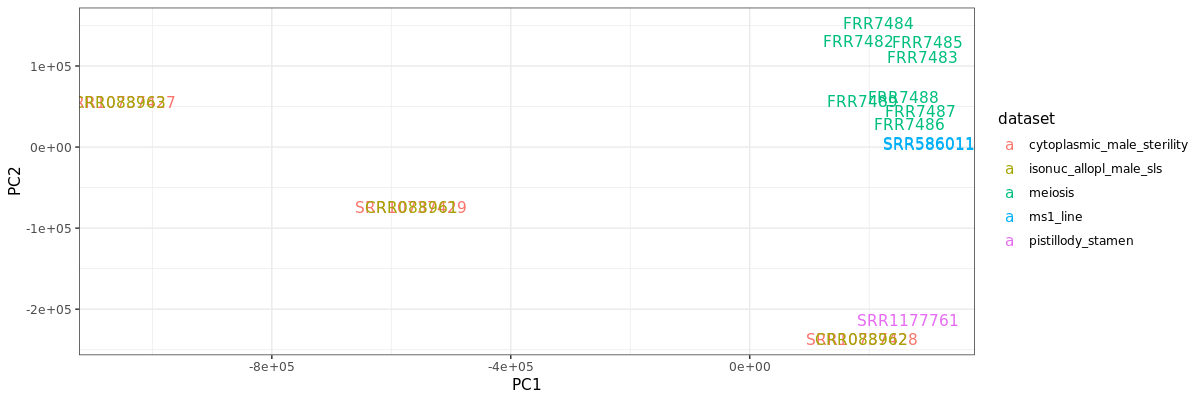

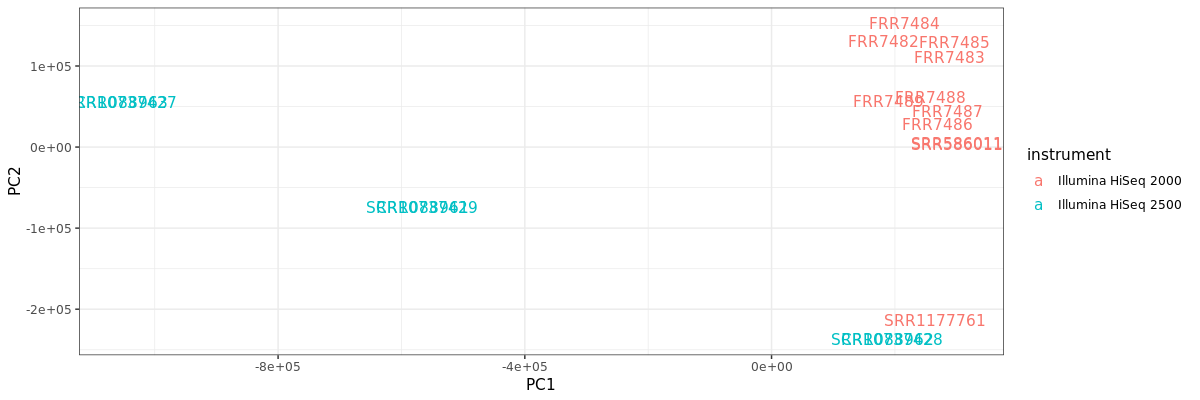

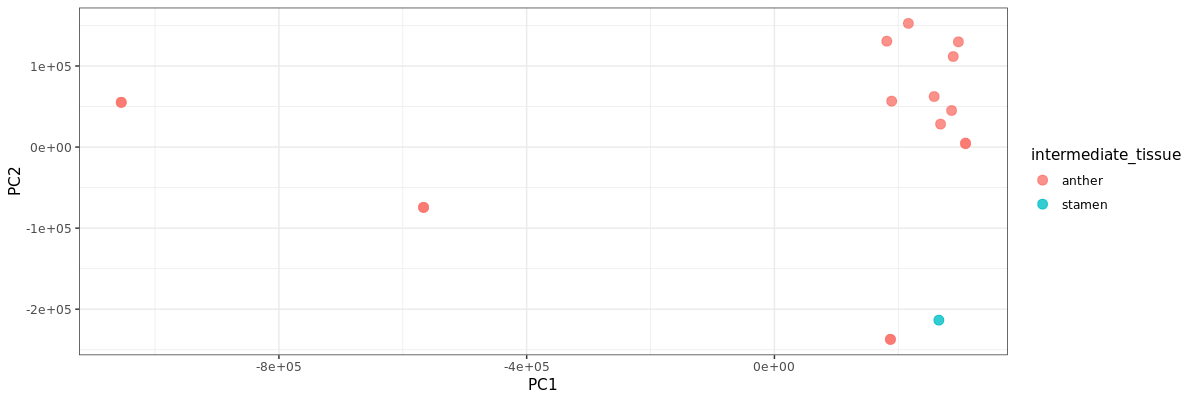

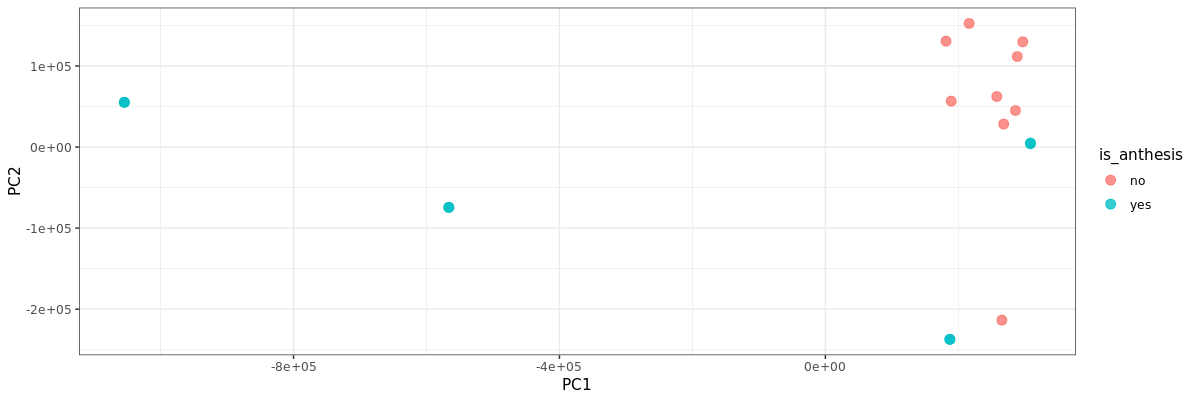

In [174]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_6, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'is_anthesis',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [ ]:
# create models
so_6 <- sleuth_fit(so_6, ~instrument + is_anthesis, 'full')
so_6 <- sleuth_fit(so_6, ~instrument, 'reduced')

fitting measurement error models
shrinkage estimation
5 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1B01G357800, TraesCHI6A01G313900, TraesCHI6D01G293600, TraesCHI7A01G270800, TraesCHIUn01G298600


In [233]:
# perform DGE tests
so_6 <- sleuth_lrt(so_6, 'reduced', 'full')
so_6 <- sleuth_wt(so_6, 'is_anthesisyes', which_model = "full")

In [234]:
models(so_6)

[  full  ]
formula:  ~instrument + is_anthesis 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	is_anthesisyes
[  reduced  ]
formula:  ~instrument 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500


In [235]:
# exctract and inspect results of wald-test
so_wt6 <- sleuth_results(so_6,'is_anthesisyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig6 <- filter(so_wt6, qval < 0.05)
nrow(so_wt_sig6)
table(so_wt_sig6$b>0)

[1] 13009


FALSE  TRUE 
 7058  5951 

In [236]:
# extract and inspect results of lrt
so_lrt6 <- sleuth_results(so_6, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all6 <- na.omit(merge(so_lrt6, so_wt6, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all6, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.03661473,0.1023499,4.368243,1.217075,1,3.6849269,11.184524,0.000804127,0.08033418,⋯,0.15095250,0.35216396,-0.3728152,0.2595890,3.6849269,11.184524,0.000804127,0.06988405,0.1094646,0.1094646
2,TraesCHI1A01G000300,0.01639455,0.0635526,5.760055,8.915424,1,0.9573194,2.135919,0.074200979,0.52016061,⋯,0.02078742,0.08758114,-1.2828282,0.5548989,0.9573194,2.135919,0.074200979,0.37026651,0.4296563,0.4296563
3,TraesCHI1A01G000400,0.03622427,0.1018313,4.386516,4.870712,1,2.2434125,5.302062,0.013583382,0.31113078,⋯,0.07711687,0.22476799,0.8077834,0.4569776,2.2434125,5.302062,0.013583382,0.25805678,0.3281360,0.3281360


In [237]:
# inspect sig genes
table(so_all6$qval.lrt<0.05)
table(so_all6$qval.wt<0.05)
table(so_all6$qval.lrt<0.05,so_all6$qval.wt<0.05)


FALSE  TRUE 
50737 14858 


FALSE  TRUE 
52586 13009 

       
        FALSE  TRUE
  FALSE 50737     0
  TRUE   1849 13009

In [238]:
table6 <- select(so_all6, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig6_1 <- filter(table6, qval.lrt <= 0.1)
glimpse(sig6_1)
sig6_05 <- filter(table6, qval.lrt <= 0.05)
glimpse(sig6_05)
sig6_01 <- filter(table6, qval.lrt <= 0.01)
glimpse(sig6_01)
# look at table and few of 0.05
head(sig6_05, 5)

Rows: 22,938
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000600", "TraesCHI1A01…
$ test_stat <dbl> 5.760055, 4.549132, 5.051978, 41.086649, 21.693037, 4.65749…
$ b         <dbl> -1.2828282, -3.0336153, 0.5160424, -2.3860195, -2.0688328, …
$ qval.lrt  <dbl> 6.355260e-02, 9.671847e-02, 8.195322e-02, 1.704333e-08, 8.5…
$ qval.wt   <dbl> 8.758114e-02, 1.265279e-01, 9.987685e-02, 4.570773e-31, 8.7…
Rows: 14,858
Columns: 5
$ target_id <chr> "TraesCHI1A01G005000", "TraesCHI1A01G006000", "TraesCHI1A01…
$ test_stat <dbl> 41.086649, 21.693037, 7.753574, 11.514959, 49.631924, 29.50…
$ b         <dbl> -2.3860195, -2.0688328, -0.4302185, -1.1099144, 2.0429384, …
$ qval.lrt  <dbl> 1.704333e-08, 8.517513e-05, 2.957864e-02, 6.434458e-03, 4.1…
$ qval.wt   <dbl> 4.570773e-31, 8.763395e-06, 4.572618e-02, 2.031622e-03, 1.2…
Rows: 8,106
Columns: 5
$ target_id <chr> "TraesCHI1A01G005000", "TraesCHI1A01G006000", "TraesCHI1A01…
$ test_stat <dbl> 41.08665, 21.69304, 11.51496, 49.63192, 29

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G005000,41.086649,-2.3860195,1.704333e-08,4.570773e-31
2,TraesCHI1A01G006000,21.693037,-2.0688328,8.517513e-05,8.763395e-06
3,TraesCHI1A01G006900,7.753574,-0.4302185,2.957864e-02,4.572618e-02
4,TraesCHI1A01G007000,11.514959,-1.1099144,6.434458e-03,2.031622e-03
5,TraesCHI1A01G007100,49.631924,2.0429384,4.195164e-10,1.285577e-37


In [239]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig6_1, file = "wdeg6_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig6_05, file = "wdeg6_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig6_01, file = "wdeg6_signif0_01.csv", sep = ",", col.names = TRUE)

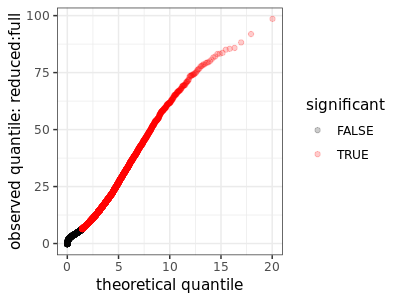

In [240]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_6, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

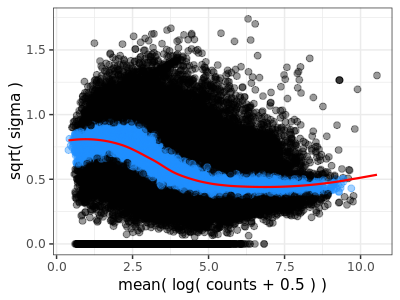

In [241]:
plot_mean_var(so_6, which_model="full")

# 7. Contrast: **flower vs anther**
* using only flower tissues, 
* targeting tissue difference, 
* correcting with time (Zadok_scale),
* mutants excluded
     - `null = instrument + Zadok_scale`
     - `full = instrument + Zadok_scale + is_anther`

## Creating contrast variables
* **is_anther** = yes = only anther wt tissues, no = flower tissues

In [242]:
# here filter to flower tissues only
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_tissue == "inflorescence") %>% select(ID, dataset, library, instrument, intermediate_age, intermediate_tissue, zadok_scale) 
# here we select samples that are anther/stamen tissue
is_anther_yes <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen" | intermediate_tissue == "meiocyte") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, dataset, library, instrument, intermediate_age, zadok_scale, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen" & intermediate_tissue != "meiocyte") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, dataset, library, instrument, intermediate_age, zadok_scale, is_anther)
# here we join tables of anther or not into one table
b_7 <- bind_rows(is_anther_yes, is_anther_no)
b_7$ID <- as.factor(b_7$ID)
b_7$instrument <- as.factor(b_7$instrument)
b_7$is_anther <- as.factor(b_7$is_anther)
b_7$zadok_scale <- as.factor(b_7$zadok_scale)
b_7$library <- as.factor(b_7$library)
b_7$dataset <- as.factor(b_7$dataset)
b_7$intermediate_age <- as.factor(b_7$intermediate_age)
# inspect ratios
glimpse(is_flower)
glimpse(is_anther_yes)
glimpse(is_anther_no)
# inspect full dataset
glimpse(b_7)
tail(b_7, 3)

Rows: 87
Columns: 7
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ zadok_scale         <int> 56, 56, 56, 56, 56, 56, 71, 71, 71, 71, 71, 71, 6…
Rows: 23
Columns: 7
$ ID               <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR088…
$ dataset          <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_ster…
$ library          <chr> "paired", "paired", "paired", "paired", "paired", "p…
$ instrument       <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Illum…
$ intermediate_age <chr> "Heading", "Heading", "Heading", "Heading", "Heading…
$ zadok_scal

,ID,dataset,library,instrument,intermediate_age,zadok_scale,is_anther
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
85,SRR6802613,spike_dev,paired,Illumina HiSeq 2000,Floret_development,37,no
86,SRR6802614,spike_dev,paired,Illumina HiSeq 2000,Floret_development,37,no
87,SRR6802615,spike_dev,paired,Illumina HiSeq 2000,Floret_development,37,no


In [243]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_7$ID, "abundance.h5")
names(files) <- paste0(b_7$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [244]:
s2c_7 <- mutate(b_7, path = files, sample = ID)
head(s2c_7, 3)

,ID,dataset,library,instrument,intermediate_age,zadok_scale,is_anther,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,cytoplasmic_male_sterility,paired,Illumina HiSeq 2500,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,cytoplasmic_male_sterility,paired,Illumina HiSeq 2500,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,cytoplasmic_male_sterility,paired,Illumina HiSeq 2500,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [245]:
# construct the sleuth-object
so_7 <- sleuth_prep(sample_to_covariates = s2c_7, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.......................................................................................
normalizing est_counts
60061 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60061 genes passed the filter
summarizing bootstraps
.................................................
......................................


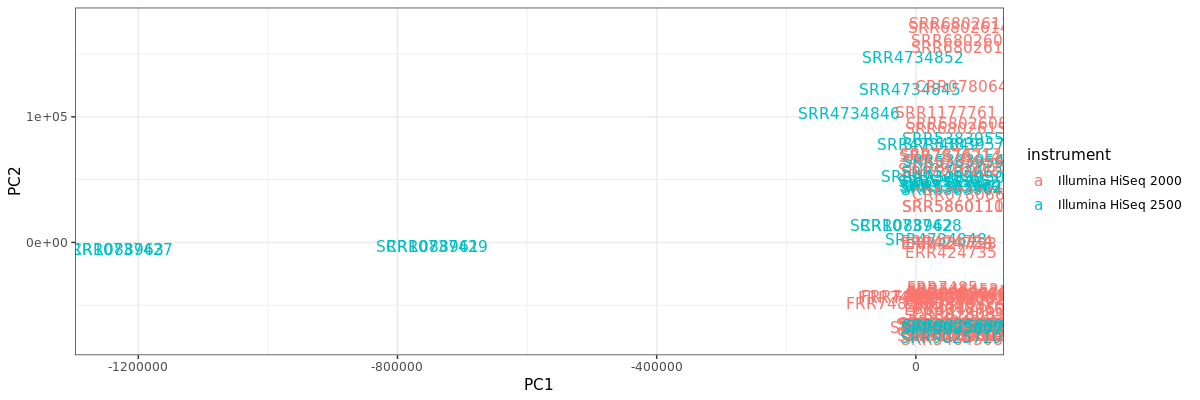

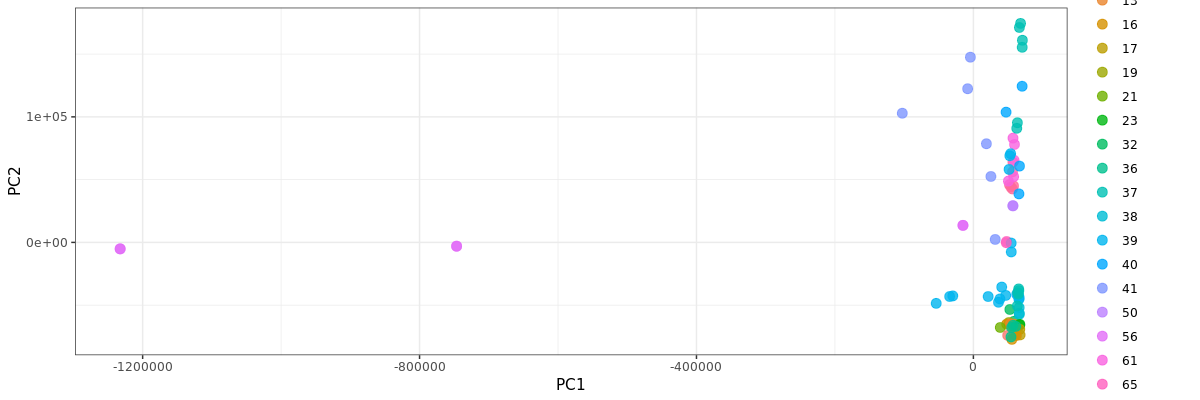

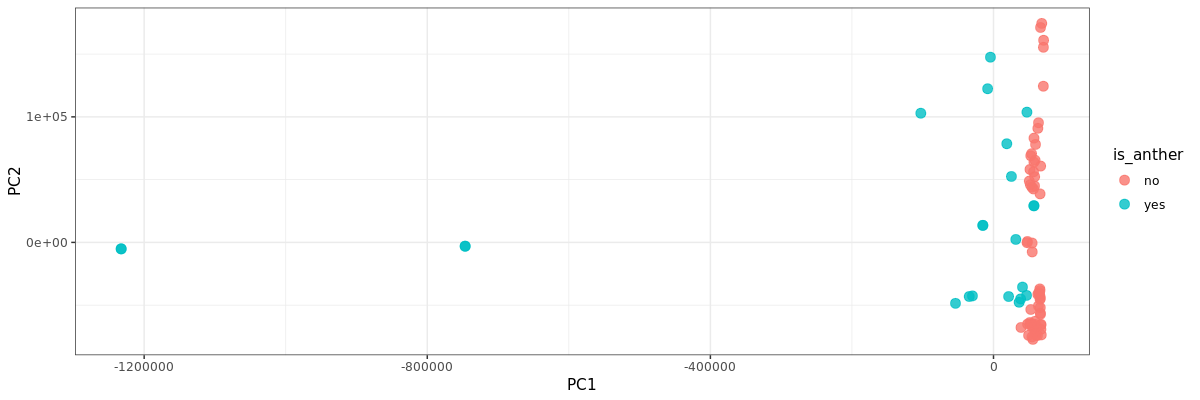

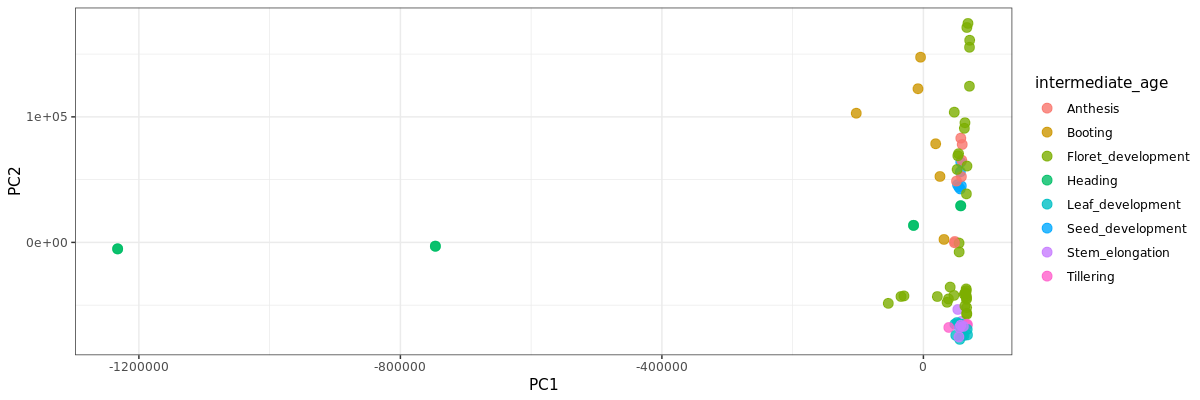

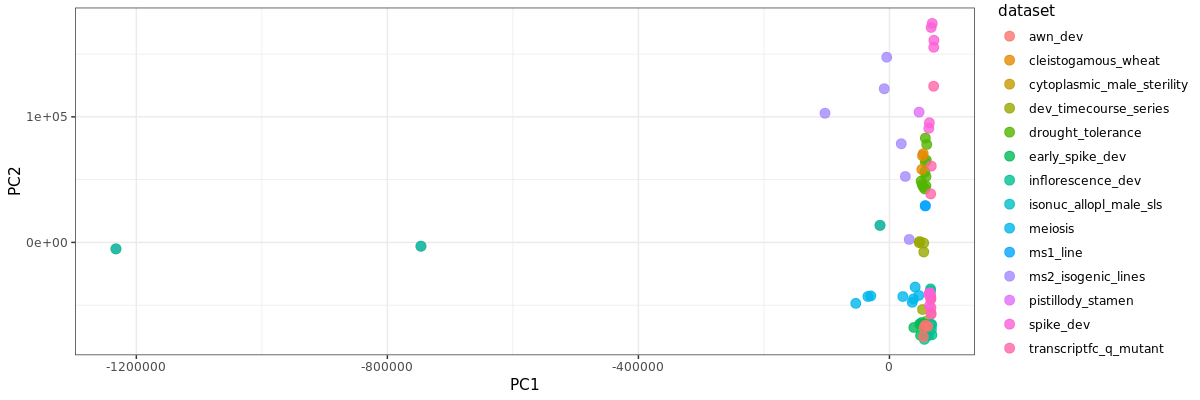

In [246]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_7, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'zadok_scale',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'intermediate_age',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'dataset',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [247]:
# create models
so_7 <- sleuth_fit(so_7, ~instrument + intermediate_age + is_anther, 'full')
so_7 <- sleuth_fit(so_7, ~instrument + intermediate_age, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1A01G385200
computing variance of betas
fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1A01G385200
computing variance of betas


In [248]:
# perform DGE tests
so_7 <- sleuth_lrt(so_7, 'reduced', 'full')
so_7 <- sleuth_wt(so_7, 'is_antheryes', which_model = "full")

In [249]:
models(so_7)

[  full  ]
formula:  ~instrument + intermediate_age + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	intermediate_ageBooting
 	intermediate_ageFloret_development
 	intermediate_ageHeading
 	intermediate_ageLeaf_development
 	intermediate_ageSeed_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering
 	is_antheryes
[  reduced  ]
formula:  ~instrument + intermediate_age 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	intermediate_ageBooting
 	intermediate_ageFloret_development
 	intermediate_ageHeading
 	intermediate_ageLeaf_development
 	intermediate_ageSeed_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering


In [250]:
# exctract and inspect results of wald-test
so_wt7 <- sleuth_results(so_7,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig7 <- filter(so_wt7, qval < 0.05)
nrow(so_wt_sig7)
table(so_wt_sig7$b>0)

[1] 18072


FALSE  TRUE 
 7623 10449 

In [251]:
# extract and inspect results of lrt
so_lrt7 <- sleuth_results(so_7, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all7 <- na.omit(merge(so_lrt7, so_wt7, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all7, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.008191021,0.02320431,6.99122649,591.2620,1,3.363966,9.762228,0.04475492,7.5355275,⋯,0.01042544,0.03772746,2.62248272,1.0238516,3.363966,9.762228,0.04475492,7.0310824,0.5405905,7.0310824
2,TraesCHI1A01G000300,1.000000000,1.00000000,-0.05552843,167.2237,1,1.462335,3.206850,0.09312824,2.0507659,⋯,0.80747582,0.88206696,-0.13816904,0.5670017,1.462335,3.206850,0.09312824,2.0769352,0.9216516,2.0769352
3,TraesCHI1A01G000400,1.000000000,1.00000000,-0.08993073,66.1754,1,3.404850,2.160578,0.07567292,0.7727297,⋯,0.86497253,0.91917966,-0.06066533,0.3567545,3.404850,2.160578,0.07567292,0.7834253,0.5258628,0.7834253


In [252]:
# inspect sig genes
table(so_all7$qval.lrt<0.05)
table(so_all7$qval.wt<0.05)
table(so_all7$qval.lrt<0.05,so_all7$qval.wt<0.05)


FALSE  TRUE 
27953 32108 


FALSE  TRUE 
41989 18072 

       
        FALSE  TRUE
  FALSE 27953     0
  TRUE  14036 18072

In [253]:
table7 <- select(so_all7, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig7_1 <- filter(table7, qval.lrt <= 0.1)
glimpse(sig7_1)
sig7_05 <- filter(table7, qval.lrt <= 0.05)
glimpse(sig7_05)
sig7_01 <- filter(table7, qval.lrt <= 0.01)
glimpse(sig7_01)
# look at table and few of 0.05
head(sig7_05, 5)

Rows: 41,486
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G001700", "TraesCHI1A01…
$ test_stat <dbl> 6.991226, 31.971571, 4.930638, 8.167947, 17.741471, 4.44383…
$ b         <dbl> 2.62248272, 3.18053433, 0.10718652, -0.28438135, 0.53342511…
$ qval.lrt  <dbl> 2.320431e-02, 5.746954e-07, 4.956940e-02, 1.467272e-02, 2.7…
$ qval.wt   <dbl> 3.772746e-02, 1.803514e-07, 6.538729e-01, 1.079456e-01, 7.1…
Rows: 32,108
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G001700", "TraesCHI1A01…
$ test_stat <dbl> 6.991226, 31.971571, 4.930638, 8.167947, 17.741471, 10.8870…
$ b         <dbl> 2.6224827, 3.1805343, 0.1071865, -0.2843814, 0.5334251, -0.…
$ qval.lrt  <dbl> 2.320431e-02, 5.746954e-07, 4.956940e-02, 1.467272e-02, 2.7…
$ qval.wt   <dbl> 3.772746e-02, 1.803514e-07, 6.538729e-01, 1.079456e-01, 7.1…
Rows: 15,228
Columns: 5
$ target_id <chr> "TraesCHI1A01G001700", "TraesCHI1A01G002500", "TraesCHI1A01…
$ test_stat <dbl> 31.971571, 17.741471, 10.887046, 12.39003

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,6.991226,2.6224827,2.320431e-02,3.772746e-02
2,TraesCHI1A01G001700,31.971571,3.1805343,5.746954e-07,1.803514e-07
3,TraesCHI1A01G002300,4.930638,0.1071865,4.956940e-02,6.538729e-01
4,TraesCHI1A01G002400,8.167947,-0.2843814,1.467272e-02,1.079456e-01
5,TraesCHI1A01G002500,17.741471,0.5334251,2.707233e-04,7.176561e-04


In [254]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig7_1, file = "wdeg7_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig7_05, file = "wdeg7_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig7_01, file = "wdeg7_signif0_01.csv", sep = ",", col.names = TRUE)

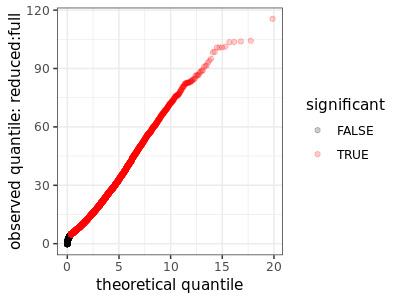

In [255]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_7, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

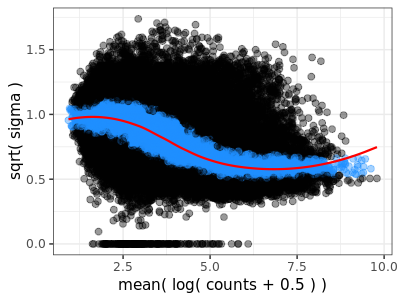

In [256]:
plot_mean_var(so_7, which_model="full")

# 8. contrast: **flower vs wt_anther** - reverse of the 7. contrast!
* using only flower tissues, 
* targeting tissue difference, 
* correcting with is_anther, 
* mutants excluded:
     - `null = instrument + is_anther`
     - `full = instrument + is_anther + Zadok_scale`

In [257]:
# create models
so_8 <- sleuth_fit(so_7, ~instrument + is_anther + intermediate_age, 'full')
so_8 <- sleuth_fit(so_7, ~instrument + is_anther, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1A01G385200
computing variance of betas
fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1B01G114900, TraesCHI1B01G119100, TraesCHI1A01G385200
computing variance of betas


In [258]:
# perform DGE tests
so_8 <- sleuth_lrt(so_8, 'reduced', 'full')
# choose appropriate one here!
so_8 <- sleuth_wt(so_8, 'intermediate_ageFloret_development', which_model = "full")

In [259]:
models(so_8)

[  full  ]
formula:  ~instrument + intermediate_age + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	intermediate_ageBooting
 	intermediate_ageFloret_development
 	intermediate_ageHeading
 	intermediate_ageLeaf_development
 	intermediate_ageSeed_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering
 	is_antheryes
[  reduced  ]
formula:  ~instrument + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	is_antheryes


In [260]:
# exctract and inspect results of wald-test
so_wt8 <- sleuth_results(so_8,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig8 <- filter(so_wt8, qval < 0.05)
nrow(so_wt_sig8)
table(so_wt_sig8$b>0)

[1] 18072


FALSE  TRUE 
 7623 10449 

In [261]:
# extract and inspect results of lrt
so_lrt8 <- sleuth_results(so_8, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all8 <- na.omit(merge(so_lrt8, so_wt8, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all8, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,7.381217e-06,1.255553e-05,35.95849,829.1149,7,3.363966,9.762228,0.04475492,9.825661,⋯,0.01042544,0.03772746,2.62248272,1.0238516,3.363966,9.762228,0.04475492,7.0310824,0.5405905,7.0310824
2,TraesCHI1A01G000300,4.112865e-05,5.896895e-05,31.97061,242.8859,7,1.462335,3.206850,0.09312824,2.798370,⋯,0.80747582,0.88206696,-0.13816904,0.5670017,1.462335,3.206850,0.09312824,2.0769352,0.9216516,2.0769352
3,TraesCHI1A01G000400,9.977116e-07,2.144646e-06,40.52702,106.0927,7,3.404850,2.160578,0.07567292,1.187335,⋯,0.86497253,0.91917966,-0.06066533,0.3567545,3.404850,2.160578,0.07567292,0.7834253,0.5258628,0.7834253


In [262]:
# inspect sig genes
table(so_all8$qval.lrt<0.05)
table(so_all8$qval.wt<0.05)
table(so_all8$qval.lrt<0.05,so_all8$qval.wt<0.05)


FALSE  TRUE 
 2687 57374 


FALSE  TRUE 
41989 18072 

       
        FALSE  TRUE
  FALSE  1817   870
  TRUE  40172 17202

In [263]:
table8 <- select(so_all8, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig8_1 <- filter(table8, qval.lrt <= 0.1)
glimpse(sig8_1)
sig8_05 <- filter(table8, qval.lrt <= 0.05)
glimpse(sig8_05)
sig8_01 <- filter(table8, qval.lrt <= 0.01)
glimpse(sig8_01)
# look at table and few of 0.05
head(sig8_05, 5)

Rows: 58,175
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 35.95849, 31.97061, 40.52702, 13.89977, 77.11951, 59.12746,…
$ b         <dbl> 2.62248272, -0.13816904, -0.06066533, 3.18053433, 0.3818516…
$ qval.lrt  <dbl> 1.255553e-05, 5.896895e-05, 2.144646e-06, 5.535626e-02, 6.0…
$ qval.wt   <dbl> 3.772746e-02, 8.820670e-01, 9.191797e-01, 1.803514e-07, 1.8…
Rows: 57,374
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 35.95849, 31.97061, 40.52702, 77.11951, 59.12746, 34.40752,…
$ b         <dbl> 2.62248272, -0.13816904, -0.06066533, 0.38185167, 0.4324917…
$ qval.lrt  <dbl> 1.255553e-05, 5.896895e-05, 2.144646e-06, 6.092658e-13, 1.1…
$ qval.wt   <dbl> 0.0377274567, 0.8820669551, 0.9191796586, 0.1821041373, 0.1…
Rows: 55,114
Columns: 5
$ target_id <chr> "TraesCHI1A01G000100", "TraesCHI1A01G000300", "TraesCHI1A01…
$ test_stat <dbl> 35.95849, 31.97061, 40.52702, 77.11951, 5

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,35.95849,2.62248272,1.255553e-05,0.03772746
2,TraesCHI1A01G000300,31.97061,-0.13816904,5.896895e-05,0.88206696
3,TraesCHI1A01G000400,40.52702,-0.06066533,2.144646e-06,0.91917966
4,TraesCHI1A01G002100,77.11951,0.38185167,6.092658e-13,0.18210414
5,TraesCHI1A01G002200,59.12746,0.43249176,1.129562e-09,0.18961704


In [264]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig8_1, file = "wdeg8_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig8_05, file = "wdeg8_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig8_01, file = "wdeg8_signif0_01.csv", sep = ",", col.names = TRUE)

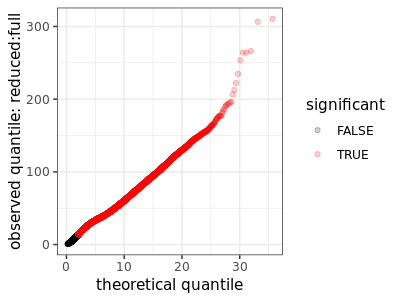

In [265]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_8, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

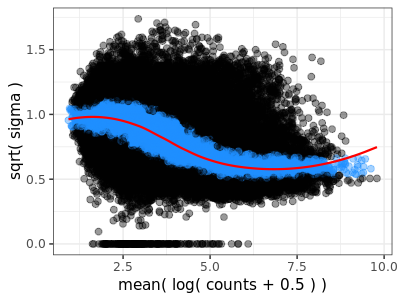

In [266]:
plot_mean_var(so_8, which_model="full")

# 9. Contrast: flower vs anther

In [267]:
# here filter to flower tissues only
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_tissue == "inflorescence") %>% select(ID, instrument, library, dataset, intermediate_tissue, zadok_scale) 
# here we select samples that are anther/stamen tissue
is_anther_yes <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen" | intermediate_tissue == "meiocyte") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, instrument, library, dataset, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen" & intermediate_tissue != "meiocyte") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, instrument, library, dataset, is_anther)
# here we join tables of anther or not into one table
b_9 <- bind_rows(is_anther_yes, is_anther_no)
b_9$ID <- as.factor(b_9$ID)
b_9$dataset <- as.factor(b_9$dataset)
b_9$is_anther <- as.factor(b_9$is_anther)
b_9$instrument <- as.factor(b_9$instrument)
b_9$library <- as.factor(b_9$library)
# inspect ratios
glimpse(is_flower)
glimpse(is_anther_yes)
glimpse(is_anther_no)
# inspect full dataset
glimpse(b_9)
tail(b_9, 3)

Rows: 87
Columns: 6
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR…
$ instrument          <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Il…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ zadok_scale         <int> 56, 56, 56, 56, 56, 56, 71, 71, 71, 71, 71, 71, 6…
Rows: 23
Columns: 5
$ ID         <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR088963", …
$ instrument <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Illumina Hi…
$ library    <chr> "paired", "paired", "paired", "paired", "paired", "paired"…
$ dataset    <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility"…
$ is_anther  <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "y…
Rows: 64
Columns: 5
$ ID         <chr> "SRR5383964", "SRR5383963", "SRR5383962", "SRR538396

,ID,instrument,library,dataset,is_anther
,<fct>,<fct>,<fct>,<fct>,<fct>
85,SRR6802613,Illumina HiSeq 2000,paired,spike_dev,no
86,SRR6802614,Illumina HiSeq 2000,paired,spike_dev,no
87,SRR6802615,Illumina HiSeq 2000,paired,spike_dev,no


In [268]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_9$ID, "abundance.h5")
names(files) <- paste0(b_9$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [269]:
s2c_9 <- mutate(b_9, path = files, sample = ID)
head(s2c_9, 3)

,ID,instrument,library,dataset,is_anther,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,Illumina HiSeq 2500,paired,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,Illumina HiSeq 2500,paired,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,Illumina HiSeq 2500,paired,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [270]:
# construct the sleuth-object
so_9 <- sleuth_prep(sample_to_covariates = s2c_9, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.......................................................................................
normalizing est_counts
60061 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60061 genes passed the filter
summarizing bootstraps
.................................................
......................................


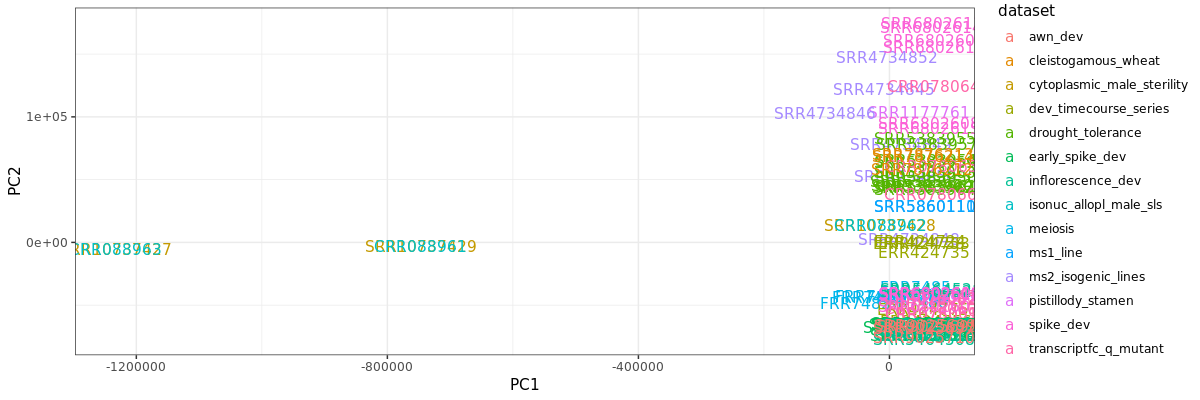

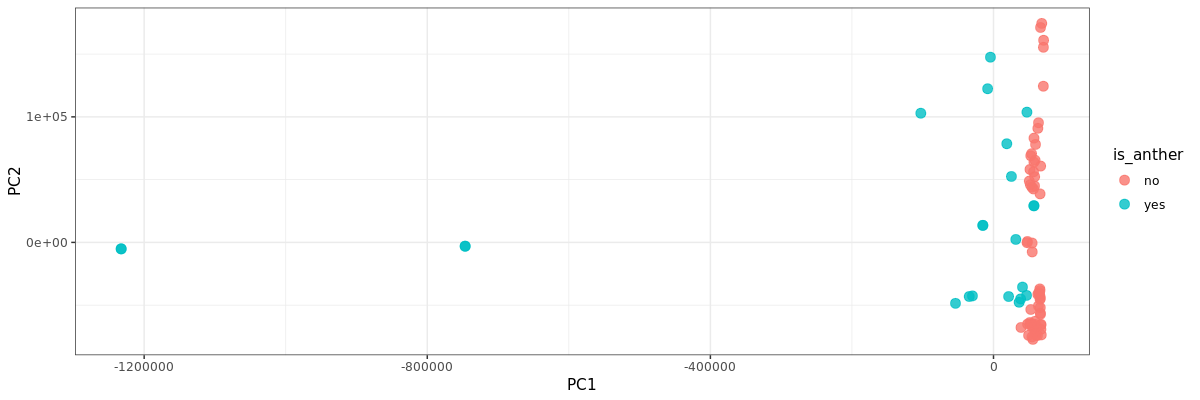

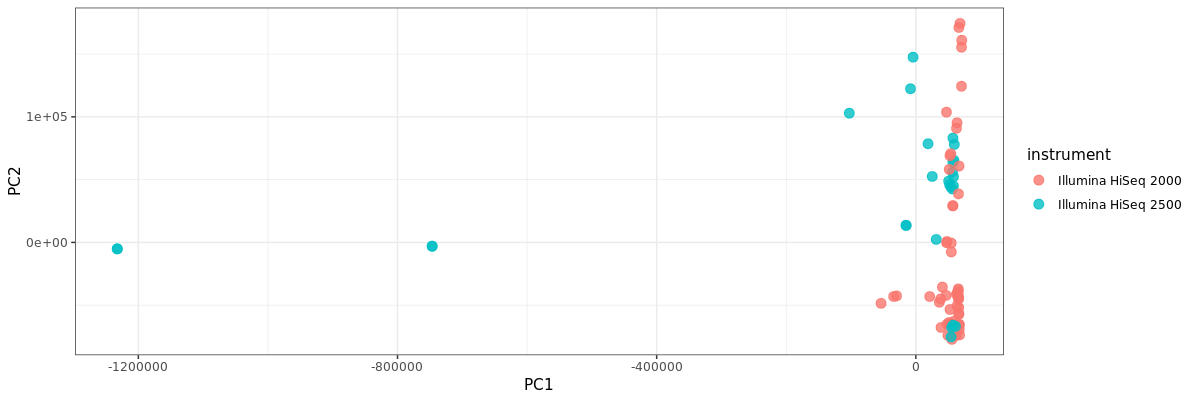

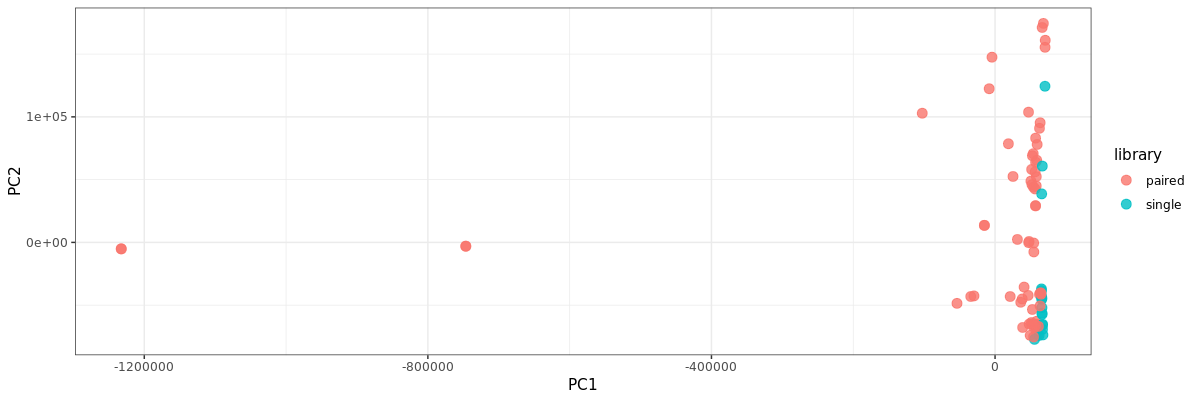

In [271]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_9, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'instrument',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'library',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [272]:
# create models
so_9 <- sleuth_fit(so_9, ~dataset + is_anther, 'full')
so_9 <- sleuth_fit(so_9, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [273]:
# perform DGE tests
so_9 <- sleuth_lrt(so_9, 'reduced', 'full')
so_9 <- sleuth_wt(so_9, 'is_antheryes', which_model = "full")

In [274]:
models(so_9)

[  full  ]
formula:  ~dataset + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettranscriptfc_q_mutant
 	is_antheryes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettranscriptfc_q_mutant


In [275]:
# exctract and inspect results of wald-test
so_wt9 <- sleuth_results(so_9,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig9 <- filter(so_wt9, qval < 0.05)
nrow(so_wt_sig9)
table(so_wt_sig9$b>0)

[1] 880


FALSE  TRUE 
  313   567 

In [276]:
# extract and inspect results of lrt
so_lrt9 <- sleuth_results(so_9, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all9 <- na.omit(merge(so_lrt9, so_wt9, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all9, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.255307127,0.67390254,1.294027,30.56387,1,3.363966,9.762228,0.04475492,0.3739282,⋯,0.264101382,0.83873695,-1.020187,0.9135321,3.363966,9.762228,0.04475492,0.3725156,0.2317379,0.3725156
2,TraesCHI1A01G000300,0.002521218,0.08202973,9.125131,27.89794,1,1.462335,3.206850,0.09312824,0.2890353,⋯,0.003417192,0.11878490,-3.093704,1.0567800,1.462335,3.206850,0.09312824,0.2278778,0.4652637,0.4652637
3,TraesCHI1A01G000400,0.001052942,0.04905213,10.732076,17.75454,1,3.404850,2.160578,0.07567292,0.1675399,⋯,0.001229556,0.06760633,-2.505963,0.7753759,3.404850,2.160578,0.07567292,0.1273078,0.2249310,0.2249310


In [277]:
# inspect sig genes
table(so_all9$qval.lrt<0.05)
table(so_all9$qval.wt<0.05)
table(so_all9$qval.lrt<0.05,so_all9$qval.wt<0.05)


FALSE  TRUE 
58751  1310 


FALSE  TRUE 
59181   880 

       
        FALSE  TRUE
  FALSE 58751     0
  TRUE    430   880

In [278]:
table9 <- select(so_all9, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig9_1 <- filter(table9, qval.lrt <= 0.1)
glimpse(sig9_1)
sig9_05 <- filter(table9, qval.lrt <= 0.05)
glimpse(sig9_05)
sig9_01 <- filter(table9, qval.lrt <= 0.01)
glimpse(sig9_01)
# look at table and few of 0.05
head(sig9_05, 5)

Rows: 2,100
Columns: 5
$ target_id <chr> "TraesCHI1A01G000300", "TraesCHI1A01G000400", "TraesCHI1A01…
$ test_stat <dbl> 9.125131, 10.732076, 9.603130, 19.770912, 12.188264, 13.881…
$ b         <dbl> -3.093704, -2.505963, -1.280220, 4.651050, -3.921601, -2.07…
$ qval.lrt  <dbl> 0.0820297288, 0.0490521267, 0.0697763518, 0.0021057827, 0.0…
$ qval.wt   <dbl> 0.1187848987, 0.0676063260, 0.0909293408, 0.0035358371, 0.0…
Rows: 1,310
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G032800", "TraesCHI1A01…
$ test_stat <dbl> 10.73208, 19.77091, 12.18826, 13.88111, 13.73899, 11.56572,…
$ b         <dbl> -2.505963, 4.651050, -3.921601, -2.076925, 5.446078, 4.3427…
$ qval.lrt  <dbl> 4.905213e-02, 2.105783e-03, 3.063285e-02, 1.714015e-02, 1.7…
$ qval.wt   <dbl> 6.760633e-02, 3.535837e-03, 5.586829e-02, 3.244677e-02, 3.4…
Rows: 508
Columns: 5
$ target_id <chr> "TraesCHI1A01G032800", "TraesCHI1A01G063300", "TraesCHI1A01…
$ test_stat <dbl> 19.77091, 20.31942, 24.35938, 16.98477, 24.830

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000400,10.73208,-2.505963,0.049052127,0.067606326
2,TraesCHI1A01G032800,19.77091,4.651050,0.002105783,0.003535837
3,TraesCHI1A01G040500,12.18826,-3.921601,0.030632849,0.055868292
4,TraesCHI1A01G042900,13.88111,-2.076925,0.017140147,0.032446768
5,TraesCHI1A01G044200,13.73899,5.446078,0.017945542,0.034122552


In [279]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig9_1, file = "wdeg9_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig9_05, file = "wdeg9_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig9_01, file = "wdeg9_signif0_01.csv", sep = ",", col.names = TRUE)

# 10. **is_sterile vs wt_anther** 
* using only anther tissues, 
* targeting wt-mut differences, 
* correcting with time (Zadok_scale/intermediate_age):
     - `null = instrument + Zadok_scale`
     - `full = instrument + Zadok_scale + is_mutant`

In [280]:
# here filter for anther tissues only
is_anther <- b_meta %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen") %>% 
                        filter(ID != "SRR1177760") %>% # exclude non-sterile mutant
                        select(ID, dataset, instrument, library, intermediate_age, zadok_scale, gm) 
# here we select mutants
is_mutant_yes <- is_anther %>% filter(gm == "mut") %>% 
                            add_column(is_mutant = "yes") %>% 
                            select(ID, dataset, instrument, library, intermediate_age, zadok_scale, is_mutant)
# here we select wild types
is_mutant_no <- is_anther %>% filter(gm == "wt") %>% 
                            add_column(is_mutant = "no") %>% 
                            select(ID, dataset, instrument, library,  intermediate_age, zadok_scale, is_mutant)
# here we join tables of mutant or not into one table
b_10 <- bind_rows(is_mutant_yes, is_mutant_no)
b_10$ID <- as.factor(b_10$ID)
b_10$dataset <- as.factor(b_10$dataset)
b_10$library <- as.factor(b_10$library)
b_10$instrument <- as.factor(b_10$instrument)
b_10$intermediate_age <- as.factor(b_10$intermediate_age)
b_10$zadok_scale <- as.factor(b_10$zadok_scale)
b_10$is_mutant <- as.factor(b_10$is_mutant)
glimpse(is_anther)
glimpse(is_mutant_yes)
glimpse(is_mutant_no)
glimpse(b_10)
tail(b_10, 3)

Rows: 51
Columns: 7
$ ID               <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR107…
$ dataset          <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_ster…
$ instrument       <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Illum…
$ library          <chr> "paired", "paired", "paired", "paired", "paired", "p…
$ intermediate_age <chr> "Heading", "Heading", "Heading", "Heading", "Heading…
$ zadok_scale      <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, …
$ gm               <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt", "…
Rows: 28
Columns: 7
$ ID               <chr> "SRR10737430", "SRR10737431", "SRR10737432", "CRR088…
$ dataset          <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_ster…
$ instrument       <chr> "Illumina HiSeq 2500", "Illumina HiSeq 2500", "Illum…
$ library          <chr> "paired", "paired", "paired", "paired", "paired", "p…
$ intermediate_age <chr> "Heading", "Heading", "Heading", "Heading", "Heading…
$ zadok_scal

,ID,dataset,instrument,library,intermediate_age,zadok_scale,is_mutant
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
49,SRR4734852,ms2_isogenic_lines,Illumina HiSeq 2500,paired,Booting,41,no
50,SRR5860110,ms1_line,Illumina HiSeq 2000,paired,Heading,50,no
51,SRR5860111,ms1_line,Illumina HiSeq 2000,paired,Heading,50,no


In [281]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_10$ID, "abundance.h5")
names(files) <- paste0(b_10$ID)
head(files)
all(file.exists(files))

SRR10737430 
"../04_Kallisto_allreads_symlinked/SRR10737430/abundance.h5" 
                                                 SRR10737431 
"../04_Kallisto_allreads_symlinked/SRR10737431/abundance.h5" 
                                                 SRR10737432 
"../04_Kallisto_allreads_symlinked/SRR10737432/abundance.h5" 
                                                   CRR088960 
  "../04_Kallisto_allreads_symlinked/CRR088960/abundance.h5" 
                                                   CRR088959 
  "../04_Kallisto_allreads_symlinked/CRR088959/abundance.h5" 
                                                   CRR088958 
  "../04_Kallisto_allreads_symlinked/CRR088958/abundance.h5"

[1] TRUE

In [282]:
s2c_10 <- mutate(b_10, path = files, sample = ID)
head(s2c_10, 3)

,ID,dataset,instrument,library,intermediate_age,zadok_scale,is_mutant,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737430,cytoplasmic_male_sterility,Illumina HiSeq 2500,paired,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737430/abundance.h5,SRR10737430
2,SRR10737431,cytoplasmic_male_sterility,Illumina HiSeq 2500,paired,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737431/abundance.h5,SRR10737431
3,SRR10737432,cytoplasmic_male_sterility,Illumina HiSeq 2500,paired,Heading,56,yes,../04_Kallisto_allreads_symlinked/SRR10737432/abundance.h5,SRR10737432


In [283]:
# construct the sleuth-object
so_10 <- sleuth_prep(sample_to_covariates = s2c_10, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...................................................
normalizing est_counts
65540 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
65540 genes passed the filter
summarizing bootstraps
.................................................
..


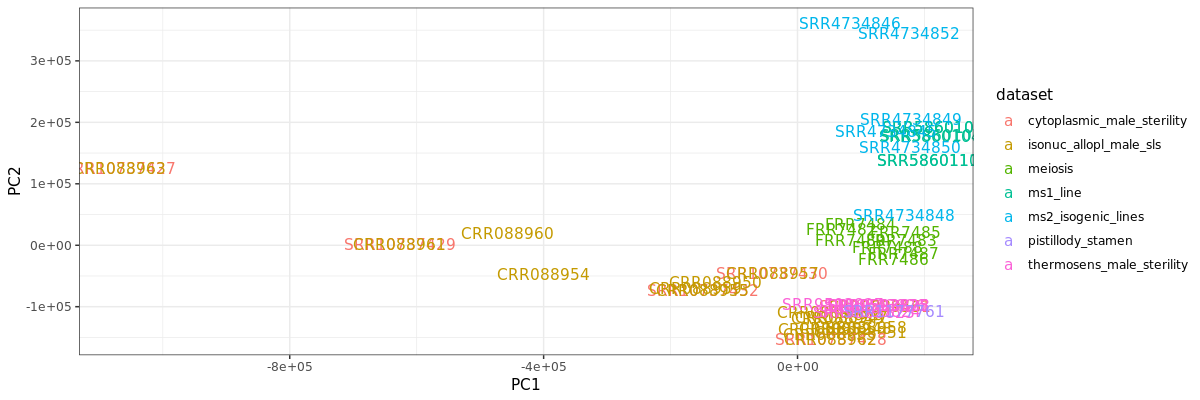

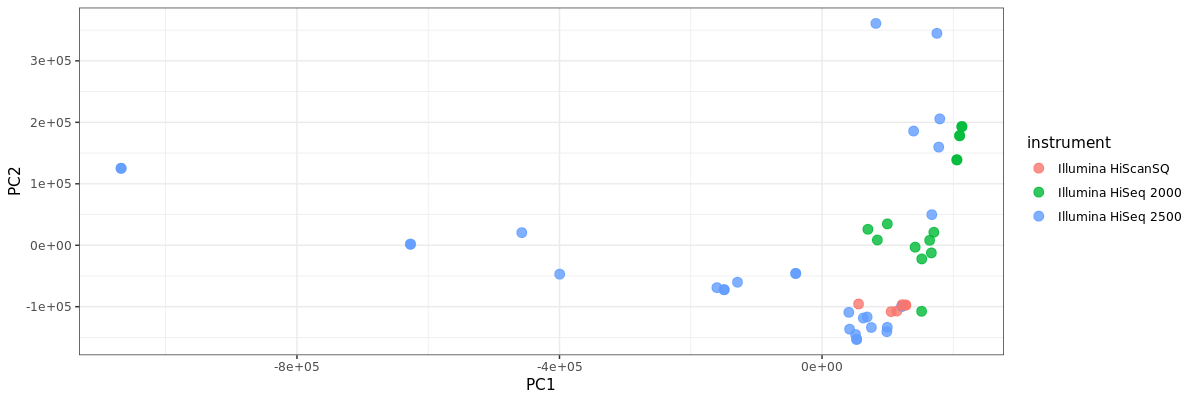

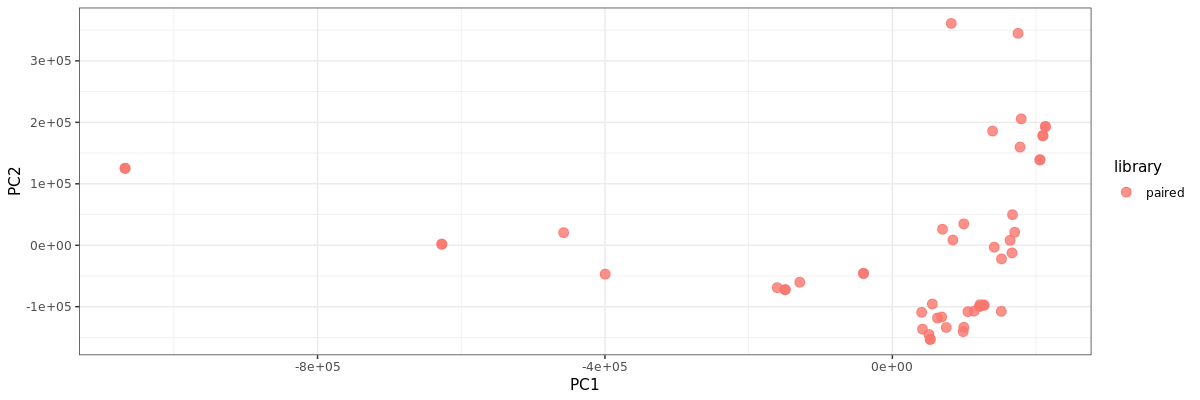

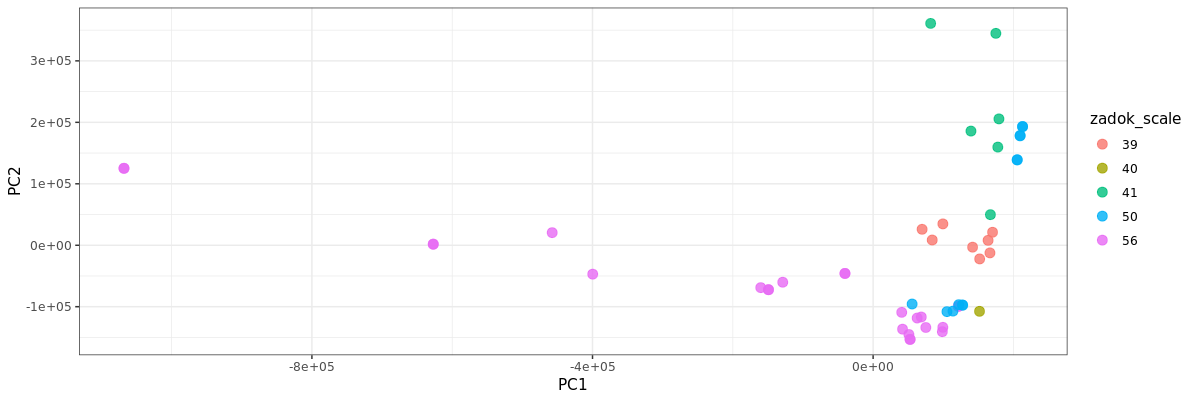

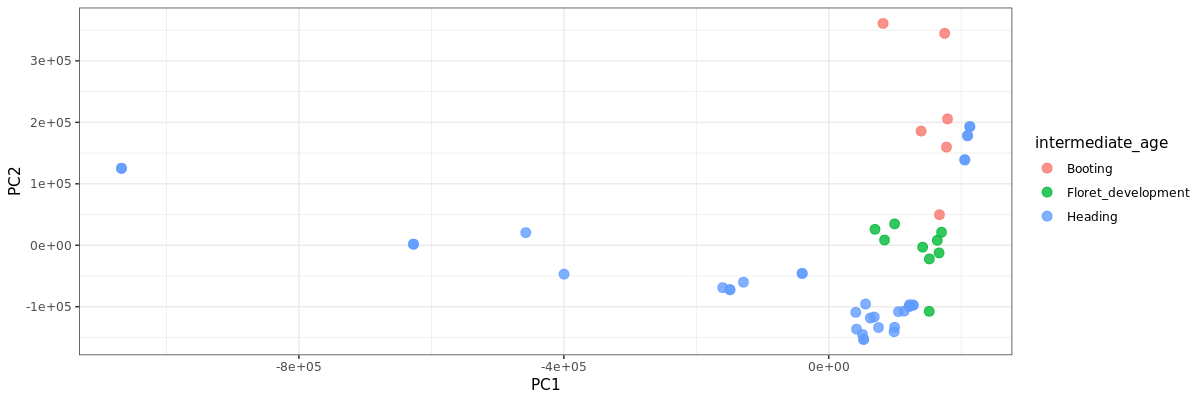

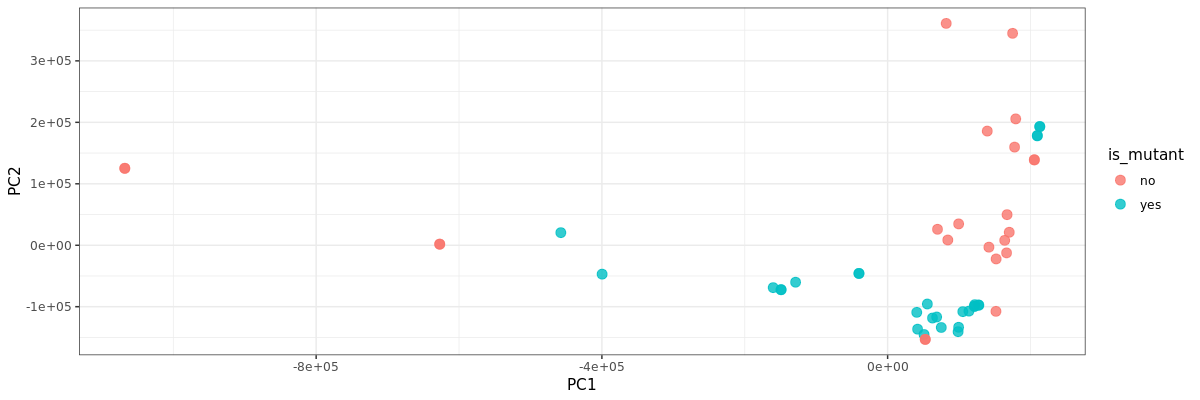

In [284]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_10, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_10, color_by = 'instrument',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_10, color_by = 'library',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_10, color_by = 'zadok_scale',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_10, color_by = 'intermediate_age',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_10, color_by = 'is_mutant',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [301]:
# create models
so_10 <- sleuth_fit(so_10, ~instrument + intermediate_age + is_mutant, 'full')
so_10 <- sleuth_fit(so_10, ~instrument + intermediate_age, 'reduced')

fitting measurement error models
shrinkage estimation
6 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI7B01G499500, TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI5A01G280900, TraesCHI7A01G270800, TraesCHIUn01G298600
computing variance of betas
fitting measurement error models
shrinkage estimation
6 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI7B01G499500, TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI5A01G280900, TraesCHI7A01G270800, TraesCHIUn01G298600
computing variance of betas


In [302]:
# perform DGE tests
so_10 <- sleuth_lrt(so_10, 'reduced', 'full')
so_10 <- sleuth_wt(so_10, 'is_mutantyes', which_model = "full")

In [303]:
models(so_10)

[  full  ]
formula:  ~instrument + intermediate_age + is_mutant 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2000
 	instrumentIllumina HiSeq 2500
 	intermediate_ageFloret_development
 	intermediate_ageHeading
 	is_mutantyes
[  reduced  ]
formula:  ~instrument + intermediate_age 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2000
 	instrumentIllumina HiSeq 2500
 	intermediate_ageFloret_development
 	intermediate_ageHeading


In [304]:
# exctract and inspect results of wald-test
so_wt10 <- sleuth_results(so_10,'is_mutantyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig10 <- filter(so_wt10, qval < 0.05)
nrow(so_wt_sig10)
table(so_wt_sig10$b>0)

[1] 15700


FALSE  TRUE 
 7630  8070 

In [305]:
# extract and inspect results of lrt
so_lrt10 <- sleuth_results(so_10, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all10 <- na.omit(merge(so_lrt10, so_wt10, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all10, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000400,0.001268677,0.008650552,10.387552,36.23962,1,1.776409,3.173951,0.2099525,0.5778652,⋯,0.001425085,0.01018651,1.0895088,0.3415900,1.776409,3.173951,0.2099525,0.4414981,0.4707027,0.4707027
2,TraesCHI1A01G000600,0.123344399,0.177971334,2.374331,95.70860,1,2.428180,4.046633,0.2006851,1.8799366,⋯,0.133059105,0.28619651,-0.8851136,0.5892323,2.428180,4.046633,0.2006851,1.8246174,0.3581609,1.8246174
3,TraesCHI1A01G000900,0.015322125,0.050210603,5.879046,303.90841,1,2.874512,11.829226,0.9443911,5.6623134,⋯,0.017776044,0.06707594,-2.4046635,1.0145188,2.874512,11.829226,0.9443911,5.0595578,0.2820679,5.0595578


In [306]:
# inspect sig genes
table(so_all10$qval.lrt<0.05)
table(so_all10$qval.wt<0.05)
table(so_all10$qval.lrt<0.05,so_all10$qval.wt<0.05)


FALSE  TRUE 
45596 19944 


FALSE  TRUE 
49840 15700 

       
        FALSE  TRUE
  FALSE 45596     0
  TRUE   4244 15700

In [307]:
table10 <- select(so_all10, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig10_1 <- filter(table10, qval.lrt <= 0.1)
glimpse(sig10_1)
sig10_05 <- filter(table10, qval.lrt <= 0.05)
glimpse(sig10_05)
sig10_01 <- filter(table10, qval.lrt <= 0.01)
glimpse(sig10_01)
# look at table and few of 0.05
head(sig10_05, 5)

Rows: 30,629
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G000900", "TraesCHI1A01…
$ test_stat <dbl> 10.387552, 5.879046, 6.271827, 9.530234, 8.455497, 20.31842…
$ b         <dbl> 1.08950883, -2.40466353, -1.18542984, -0.30094963, -0.27976…
$ qval.lrt  <dbl> 0.0086505520, 0.0502106031, 0.0431042081, 0.0121492145, 0.0…
$ qval.wt   <dbl> 1.018651e-02, 6.707594e-02, 5.688908e-02, 3.541255e-02, 4.6…
Rows: 19,944
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G001800", "TraesCHI1A01…
$ test_stat <dbl> 10.387552, 6.271827, 9.530234, 8.455497, 20.318425, 8.34894…
$ b         <dbl> 1.0895088, -1.1854298, -0.3009496, -0.2797605, -0.4676795, …
$ qval.lrt  <dbl> 0.0086505520, 0.0431042081, 0.0121492145, 0.0184247985, 0.0…
$ qval.wt   <dbl> 1.018651e-02, 5.688908e-02, 3.541255e-02, 4.652857e-02, 1.5…
Rows: 10,183
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G002500", "TraesCHI1A01…
$ test_stat <dbl> 10.38755, 20.31843, 12.14381, 16.61793, 1

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000400,10.387552,1.0895088,0.0086505520,0.0101865050
2,TraesCHI1A01G001800,6.271827,-1.1854298,0.0431042081,0.0568890803
3,TraesCHI1A01G002300,9.530234,-0.3009496,0.0121492145,0.0354125473
4,TraesCHI1A01G002400,8.455497,-0.2797605,0.0184247985,0.0465285711
5,TraesCHI1A01G002500,20.318425,-0.4676795,0.0002213176,0.0001556871


In [308]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig10_1, file = "wdeg10_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig10_05, file = "wdeg10_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig10_01, file = "wdeg10_signif0_01.csv", sep = ",", col.names = TRUE)

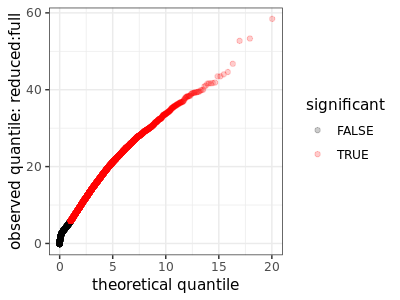

In [309]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_10, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

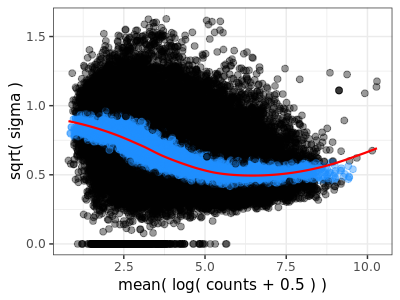

In [310]:
plot_mean_var(so_10,which_model="full")

# 11. **is_sterile vs wt_anther** 
* using only anther tissues, 
* targeting wt-mut differences, 
* correcting with time (Zadok_scale/intermediate_age):
     - `null = instrument + is_mutant `
     - `full = instrument + is_mutant + intermediate_age`

In [311]:
# create models
so_11 <- sleuth_fit(so_10, ~instrument + is_mutant + intermediate_age, 'full')
so_11 <- sleuth_fit(so_10, ~instrument + is_mutant, 'reduced')

fitting measurement error models
shrinkage estimation
6 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI7B01G499500, TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI5A01G280900, TraesCHI7A01G270800, TraesCHIUn01G298600
computing variance of betas
fitting measurement error models
shrinkage estimation
7 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI1D01G418300, TraesCHI5A01G280900, TraesCHI6B01G279000, TraesCHI7A01G270800, TraesCHIUn01G298600
computing varia

In [312]:
# perform DGE tests
so_11 <- sleuth_lrt(so_11, 'reduced', 'full')
so_11 <- sleuth_wt(so_11, 'is_mutantyes', which_model = "full")

In [313]:
models(so_11)

[  full  ]
formula:  ~instrument + intermediate_age + is_mutant 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2000
 	instrumentIllumina HiSeq 2500
 	intermediate_ageFloret_development
 	intermediate_ageHeading
 	is_mutantyes
[  reduced  ]
formula:  ~instrument + is_mutant 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2000
 	instrumentIllumina HiSeq 2500
 	is_mutantyes


In [314]:
# exctract and inspect results of wald-test
so_wt11 <- sleuth_results(so_11,'is_mutantyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig11 <- filter(so_wt11, qval < 0.05)
nrow(so_wt_sig11)
table(so_wt_sig11$b>0)

[1] 15700


FALSE  TRUE 
 7630  8070 

In [315]:
# extract and inspect results of lrt
so_lrt11 <- sleuth_results(so_11, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all11 <- na.omit(merge(so_lrt11, so_wt11, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all11, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000400,2.290265e-06,6.246617e-06,25.973686,49.28707,2,1.776409,3.173951,0.2099525,0.8387085,⋯,0.001425085,0.01018651,1.0895088,0.3415900,1.776409,3.173951,0.2099525,0.4414981,0.4707027,0.4707027
2,TraesCHI1A01G000600,2.600678e-06,6.978156e-06,25.719477,151.55589,2,2.428180,4.046633,0.2006851,3.0239083,⋯,0.133059105,0.28619651,-0.8851136,0.5892323,2.428180,4.046633,0.2006851,1.8246174,0.3581609,1.8246174
3,TraesCHI1A01G000900,5.660701e-01,5.739339e-01,1.138075,277.45660,2,2.874512,11.829226,0.9443911,4.9589407,⋯,0.017776044,0.06707594,-2.4046635,1.0145188,2.874512,11.829226,0.9443911,5.0595578,0.2820679,5.0595578


In [316]:
# inspect sig genes
table(so_all11$qval.lrt<0.05)
table(so_all11$qval.wt<0.05)
table(so_all11$qval.lrt<0.05,so_all11$qval.wt<0.05)


FALSE  TRUE 
 5361 60179 


FALSE  TRUE 
49840 15700 

       
        FALSE  TRUE
  FALSE  4592   769
  TRUE  45248 14931

In [317]:
table11 <- select(so_all11, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig11_1 <- filter(table11, qval.lrt <= 0.1)
glimpse(sig11_1)
sig11_05 <- filter(table11, qval.lrt <= 0.05)
glimpse(sig11_05)
sig11_01 <- filter(table11, qval.lrt <= 0.01)
glimpse(sig11_01)
# look at table and few of 0.05
head(sig11_05, 5)

Rows: 61,557
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G000600", "TraesCHI1A01…
$ test_stat <dbl> 25.973686, 25.719477, 30.003103, 19.493442, 12.939484, 28.9…
$ b         <dbl> 1.089508832, -0.885113640, -0.814384144, -0.546789114, -1.1…
$ qval.lrt  <dbl> 6.246617e-06, 6.978156e-06, 1.032162e-06, 1.025874e-04, 1.9…
$ qval.wt   <dbl> 0.0101865050, 0.2861965068, 0.2170831325, 0.4567701582, 0.0…
Rows: 60,179
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G000600", "TraesCHI1A01…
$ test_stat <dbl> 25.973686, 25.719477, 30.003103, 19.493442, 12.939484, 28.9…
$ b         <dbl> 1.089508832, -0.885113640, -0.814384144, -0.546789114, -1.1…
$ qval.lrt  <dbl> 6.246617e-06, 6.978156e-06, 1.032162e-06, 1.025874e-04, 1.9…
$ qval.wt   <dbl> 0.0101865050, 0.2861965068, 0.2170831325, 0.4567701582, 0.0…
Rows: 56,390
Columns: 5
$ target_id <chr> "TraesCHI1A01G000400", "TraesCHI1A01G000600", "TraesCHI1A01…
$ test_stat <dbl> 25.97369, 25.71948, 30.00310, 19.49344, 1

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000400,25.97369,1.0895088,6.246617e-06,0.01018651
2,TraesCHI1A01G000600,25.71948,-0.8851136,6.978156e-06,0.28619651
3,TraesCHI1A01G001400,30.00310,-0.8143841,1.032162e-06,0.21708313
4,TraesCHI1A01G001500,19.49344,-0.5467891,1.025874e-04,0.45677016
5,TraesCHI1A01G001800,12.93948,-1.1854298,1.973044e-03,0.05688908


In [318]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig11_1, file = "wdeg11_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig11_05, file = "wdeg11_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig11_01, file = "wdeg11_signif0_01.csv", sep = ",", col.names = TRUE)

In [319]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_anther2, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"

ERROR: Error in is(obj, "sleuth"): object 'so_anther2' not found


In [ ]:
sessionInfo()